In [2]:
# jax
import jax
# jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.style.use("default")
from importlib import reload
from functools import partial

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import (OperatorModel, OperatorPDEModel,CholInducedRKHS,
                            CholOperatorModel)
# import plotting
# reload(plotting)
# from plotting import (plot_obs,plot_compare_error,
#                       plot_input_data,plot_compare_error,
#                       plot_obs_parabolic, plot_init_final_parabolic)

from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs, # changed - could live in parabolic_data_utils ?
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel,
    fit_kernel_params,log1pexp,
    inv_log1pexp,get_anisotropic_gaussianRBF
)

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution

In [2]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi

In [3]:
def run_exp_opt_err_1_5(gamma,n_obs,seed):

    # Sample m training functions as initial conditions from a GP
    m = 1
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = m,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = seed
                                        )
                            
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.


    u_true_function,_,_,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )

    # Collocation point set size
    num_grid_x = 31
    num_grid_t = 26
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(seed),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)

    # Features of u and P
    u_operators = (eval_k,) # This enforces 1_5 step method
    feature_operators = (eval_k,dx_k,dxx_k)


    # Fit parameters of kernel for u
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)
    

    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)

    k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))
    print(1/(jnp.sqrt(ML_lengthscales)))

    u_model = CholInducedRKHS(
                        tx_all,
                        u_operators,
                        k_u,
                        nugget_size = 1e-8
                        )
    

    # Get necessary tuples
    u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

    grid_features_init = (
        (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
        .reshape(
                len(tx_all),
                len(feature_operators),
                order = 'F'
            )
            )
    k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

    @vectorize_kfunc
    def k_P(x,y):
        return k_P_u_part(x[2:],y[2:])

    P_model = OperatorModel(k_P)    
        

    EqnModel = OperatorPDEModel(
        P_model,
        (u_model,),
        (tx_obs,),
        (u_obs,),
        (tx_all,),
        feature_operators,
        rhs_operator=dt_k,
        datafit_weight = 200
    )

    params_init = jnp.hstack(list(u_params_init)+[jnp.zeros(len(grid_features_init))])

    params,_ = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-11,
        max_iter = 501,
        init_alpha=0.1,
        line_search_increase_ratio=1.4,
        print_every = 100
    )
    p_adjusted,_ = adaptive_refine_solution(params,EqnModel,1e-3,500)


    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    u_sols = EqnModel.get_u_params(params)
    P_sol = EqnModel.get_P_params(params)

    print(u_sols)
    print(P_sol)

    #### Operator learning error : 1.5 step method
    # Sample m u0 new functions from a GP
    M = 3
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_new_true_functions = tuple(GP_Sampler_1D_Pinned(num_samples = M,
                                            X = xy_pts, 
                                            smooth= gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = seed
                                        )
                            )

    vec_u0_new_true_functions = tuple([np.vectorize(u) for u in u0_new_true_functions])
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.

    u_new_true_functions = []
    ut_new_true_functions = []
    interpolants_new = []
    t_vals_s_new = []
    sols_s_new = []

    for u0_new_true_function in vec_u0_new_true_functions:
        res = list(build_burgers_data(func_u0=u0_new_true_function,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999))
        u_new_true_functions.append(res[0])
        ut_new_true_functions.append(res[1])
        interpolants_new.append(res[2])
        t_vals_s_new.append(res[3])
        sols_s_new.append(res[4])

    # Colocation points for learning u
    num_grid_x = 31
    num_grid_t = 26
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    tx_all,_ = setup_problem_data(
        tx_int,
        tx_bdy,
        60,
        jax.random.PRNGKey(55),
        times_to_observe = (0,)
    )
    
    tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])   

    # Object to capture learned solution : Fixing the first ?
    u_model = CholInducedRKHS(
                        tx_all,
                        feature_operators,
                        k_u
                        )

    def get_u_pde_adj(u0_new):
        model_grid_features = EqnModel.get_stacked_eqn_features(u_sols)
        # 1_5 step method u_t
        @jit
        def get_pred_ut(input_features):
            return P_model.kernel_function(input_features,model_grid_features)@P_sol
        
        new_obs = u0_new(tx_init_bdy) 

        class PdeModel():
            datafit_weight = 50.
            @jit
            def get_grid_features(u_params):
                evaluation = u_model.evaluate_operators(feature_operators,tx_int,u_params)
                grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
                return jnp.hstack([tx_int,grid_features])
            
            @jit
            def get_grid_target(u_params):
                return u_model.evaluate_operators((dt_k,),tx_int,u_params)
            
            @jit
            def eval_obs_points(u_params):
                return u_model.point_evaluate(tx_init_bdy,u_params)
            
            @jit
            def datafit_residual(u_params):
                obs_preds = PdeModel.eval_obs_points(u_params)
                return new_obs - obs_preds
            
            @jit
            def equation_residual(u_params):
                P_features = PdeModel.get_grid_features(u_params)
                P_model_preds = get_pred_ut(P_features)
                ugrid_target = PdeModel.get_grid_target(u_params)
                return (ugrid_target - P_model_preds)
            
            @jit
            def F(u_params):
                eqn_res = PdeModel.equation_residual(u_params)
                data_res = PdeModel.datafit_residual(u_params)
                return jnp.hstack([
                    PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                    eqn_res/jnp.sqrt(len(eqn_res))
                    ])
            
            jac = jit(jacrev(F))

            def loss(u_params):
                return jnp.linalg.norm(PdeModel.F(u_params))**2
            
            @jit
            def damping_matrix(u_params):
                return u_model.kmat+1e-5 * diagpart(u_model.kmat)
            

        # OPTIMIZE
        new_u_init = jnp.zeros(tx_all.shape[0]*len(feature_operators))

        u_params_pde,_ = LevenbergMarquadtMinimize(
            new_u_init.copy(),
            PdeModel,
            beta = 0.,
            max_iter = 101,
            init_alpha=0.05,
            line_search_increase_ratio=1.4,
            print_every = 10
        )
        u_pde_adj, _ = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)

        return u_pde_adj
    
    
    # Define grid to test
    num_fine_grid = 300
    initial_time = 0
    final_time = 1
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

    true = [u(tx_fine) for u in u_new_true_functions]

    pred1_5 = [u_model.point_evaluate(tx_fine,get_u_pde_adj(u0)) for u0 in u_new_true_functions]
    i_opt_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))

    return i_opt_1_5

In [4]:
def run_exp_opt_err_SINDy(gamma,n_obs,seed):
    # Sample m training functions as initial conditions from a GP
    m = 1
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = m,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = seed
                                        )
                            
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.


    u_true_function,_,_,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )

    # Collocation point set size
    num_grid_x = 31
    num_grid_t = 26
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(seed),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)

    # Features of u and P
    u_operators = (eval_k,) # This enforces 1_5 step method
    feature_operators = (eval_k,dx_k,dxx_k)


    # Fit parameters of kernel for u
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)
    

    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)

    k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))
    print(1/(jnp.sqrt(ML_lengthscales)))

    u_model = CholInducedRKHS(
                        tx_int,
                        u_operators,
                        k_u,
                        nugget_size = 1e-8
                        )
    

    # Get necessary tuples
    u_params = u_model.get_fitted_params(tx_obs,u_obs)

    S = (
        (u_model.evaluate_operators(feature_operators,tx_int,u_params))
        .reshape(
                len(tx_int), 
                len(feature_operators),
                order = 'F'
            )
    )

    U_t = S[:,1]
    UU_x = jnp.multiply(S[:,0],S[:,2])
    U_xx = S[:,3]

    Theta = jnp.vstack([UU_x, U_xx]).T


    res_SINDy = sparsifyDynamics(Theta,U_t.reshape(-1,1),lamb = 1e-8, n = 1)
    print(res_SINDy)

    #### Operator learning error : 1.5 step method
    # Sample m u0 new functions from a GP
    M = 3
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_new_true_functions = tuple(GP_Sampler_1D_Pinned(num_samples = M,
                                            X = xy_pts, 
                                            smooth= gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = seed
                                        )
                            )

    vec_u0_new_true_functions = tuple([np.vectorize(u) for u in u0_new_true_functions])
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.

    u_new_true_functions = []
    ut_new_true_functions = []
    interpolants_new = []
    t_vals_s_new = []
    sols_s_new = []

    for u0_new_true_function in vec_u0_new_true_functions:
        res = list(build_burgers_data(func_u0=u0_new_true_function,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999))
        u_new_true_functions.append(res[0])
        ut_new_true_functions.append(res[1])
        interpolants_new.append(res[2])
        t_vals_s_new.append(res[3])
        sols_s_new.append(res[4])

    # Solve m Burgers' (learned from SINDy) equations with IC's: u0_true_functions 
    kappa = -res_SINDy[1][0]
    alpha = res_SINDy[0][0]

    u_new_pred_functions = []
    ut_new_pred_functions = []
    interpolants_new_pred = []
    t_vals_s_new_pred = []
    sols_s_new_pred = []

    for u0_new_true_function in vec_u0_new_true_functions:
        res = list(build_burgers_data(func_u0=u0_new_true_function,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999))
        u_new_pred_functions.append(res[0])
        ut_new_pred_functions.append(res[1])
        interpolants_new_pred.append(res[2])
        t_vals_s_new_pred.append(res[3])
        sols_s_new_pred.append(res[4])
    
    
    
    # Define grid to test
    num_fine_grid = 300
    initial_time = 0
    final_time = 1
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

    true = [u(tx_fine) for u in u_new_true_functions]

    pred_SINDy = [u(tx_fine) for u in u_new_pred_functions]

    
    i_opt_SINDy = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred_SINDy)]))
    

    return i_opt_SINDy

## Data-efficiency

In [11]:
err = {
    '1_5_mthd': [],
    'SINDy':   []
}

In [12]:
# Run loop
NUM_RUNS = 5
N_OBS = [int(i) for i in jnp.arange(10,80,10)]
for n_obs in N_OBS:
    i_opt_1_5 = []
    i_opt_SINDy = []
    for run in range(NUM_RUNS):
        # Run
        res_1_5 = run_exp_opt_err_1_5(2,n_obs,seed=run)
        res_SINDy = run_exp_opt_err_SINDy(2,n_obs,seed=run)
        # Append
        i_opt_1_5.append(res_1_5)
        i_opt_SINDy.append(res_SINDy)
    # Append each list    
    err['1_5_mthd'].append(i_opt_1_5)
    err['SINDy'].append(i_opt_SINDy)   
    # Save after
    jnp.save('errors_comparisons/err_1_5_w_SINDy_ourdata', err)

  0%|          | 0/10099 [00:00<?, ?it/s]

[2.17377172 0.11841907]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.005042, Jres = 8.992, alpha = 0.08333, improvement_ratio = 0.9596
Iteration 1, loss = 0.004741, Jres = 0.7362, alpha = 0.06944, improvement_ratio = 0.9977
Iteration 2, loss = 0.004569, Jres = 0.1782, alpha = 0.05787, improvement_ratio = 1.007
Iteration 3, loss = 0.004408, Jres = 0.08425, alpha = 0.04823, improvement_ratio = 1.011
Iteration 4, loss = 0.004249, Jres = 0.08071, alpha = 0.04019, improvement_ratio = 1.014
Iteration 5, loss = 0.00409, Jres = 0.08368, alpha = 0.03349, improvement_ratio = 1.016
Iteration 100, loss = 0.0002477, Jres = 8.169e-05, alpha = 8.333e-07, improvement_ratio = 0.9996
Iteration 200, loss = 0.0002201, Jres = 9.73e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 0.000209, Jres = 7.128e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 0.0002027, Jres = 6.096e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 0.0001986, Jres = 5.197e-06, alpha = 8.333e-07, improvement_ratio = 1.

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 0.00019848948614225483
Iteration 140 Step Failed
Iteration 156 Step Failed
Iteration 173 Step Failed
Iteration 176 Step Failed
Iteration 177 Step Failed
Iteration 178 Step Failed
Iteration 179 Step Failed
Iteration 180 Step Failed
Iteration 181 Step Failed
Iteration 182 Step Failed
Iteration 183 Step Failed
Iteration 184 Step Failed
Iteration 185 Step Failed
Converged by no improvement
[Array([-1.09001838e-03,  3.33165705e-02, -3.98354864e-01, -6.63212173e-02,
        1.94291312e-01,  4.41731808e-01,  6.92131372e-01,  8.72898470e-01,
        8.81487909e-01,  6.92655042e-01,  3.86092258e-01,  5.04173186e-02,
       -2.76463428e-01, -5.91812415e-01, -9.01149789e-01, -1.20400849e+00,
       -1.48816939e+00, -1.72835131e+00, -1.88976296e+00, -1.93811101e+00,
       -1.85333814e+00, -1.63903962e+00, -1.32047495e+00, -9.32647100e-01,
       -5.07504946e-01, -6.71219914e-02,  1.44998535e-03, -5.29286723e-02,
        6.22821309e-01,  1.28915053e-01, -2.54078280e-01, -6.2062

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.004849, Jres = 92.79, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0008583, Jres = 0.03847, alpha = 0.03472, improvement_ratio = 0.9167
Iteration 2, loss = 0.0004535, Jres = 0.006777, alpha = 0.02894, improvement_ratio = 0.9941
Iteration 3, loss = 0.0004257, Jres = 0.0001694, alpha = 0.02411, improvement_ratio = 0.9994
Iteration 4, loss = 0.0004037, Jres = 2.142e-05, alpha = 0.02009, improvement_ratio = 0.9998
Iteration 5, loss = 0.0003831, Jres = 1.948e-05, alpha = 0.01674, improvement_ratio = 0.9998
Iteration 10, loss = 0.0002848, Jres = 1.186e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0001982, Jres = 4.138e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0001729, Jres = 7.685e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001414, Jres = 1.407e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001287, Jres = 7.911e-07, alpha = 4.579e-06, improvement

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00014558790111154934
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001698, Jres = 66.14, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.000202, Jres = 0.03586, alpha = 0.03472, improvement_ratio = 0.9913
Iteration 2, loss = 0.0001755, Jres = 0.001197, alpha = 0.02894, improvement_ratio = 1.002
Iteration 3, loss = 0.0001659, Jres = 2.92e-05, alpha = 0.02411, improvement_ratio = 0.999
Iteration 4, loss = 0.0001592, Jres = 2.141e-05, alpha = 0.02009, improvement_ratio = 0.9989
Iteration 5, loss = 0.0001543, Jres = 2.252e-05, alpha = 0.01674, improvement_ratio = 0.9992
Iteration 10, loss = 0.0001406, Jres = 1.258e-05, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 0.0001168, Jres = 4.758e-06, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 9.823e-05, Jres = 3.435e-06, alpha = 0.0001755, improvement_ratio = 1.001
Iteration 40, loss = 8.558e-05, Jres = 3.759e-06, alpha = 2.835e-05, improvement_ratio = 1.003
Iteration 50, loss = 7.432e-05, Jres = 2.258e-06, alpha = 4.579e-06, improve

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00011989453754322803
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 St

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.002866, Jres = 89.84, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0002788, Jres = 0.02932, alpha = 0.03472, improvement_ratio = 0.9732
Iteration 2, loss = 0.000202, Jres = 0.003701, alpha = 0.02894, improvement_ratio = 0.9995
Iteration 3, loss = 0.0001923, Jres = 4.523e-05, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 0.0001869, Jres = 1.086e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.0001833, Jres = 8.833e-06, alpha = 0.01674, improvement_ratio = 1.002
Iteration 10, loss = 0.0001705, Jres = 1.233e-05, alpha = 0.006729, improvement_ratio = 1.004
Iteration 20, loss = 0.0001448, Jres = 4.998e-05, alpha = 0.001087, improvement_ratio = 1.049
Iteration 30, loss = 0.0001204, Jres = 6.948e-05, alpha = 0.0001755, improvement_ratio = 1.119
Iteration 40, loss = 0.0001047, Jres = 3.906e-05, alpha = 2.835e-05, improvement_ratio = 1.048
Iteration 50, loss = 8.958e-05, Jres = 2.791e-05, alpha = 4.579e-06, improve

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001402071530382647
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[2.17377172 0.11841907]
[[ 0.11160798]
 [-0.03360111]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[3.66372709 0.1239319 ]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.009039, Jres = 6.093, alpha = 0.08333, improvement_ratio = 0.9832
Iteration 1, loss = 0.00856, Jres = 0.4884, alpha = 0.06944, improvement_ratio = 0.9824
Iteration 2, loss = 0.008377, Jres = 0.1508, alpha = 0.05787, improvement_ratio = 1.037
Iteration 3, loss = 0.008224, Jres = 0.09911, alpha = 0.04823, improvement_ratio = 1.059
Iteration 4, loss = 0.008067, Jres = 0.1164, alpha = 0.04019, improvement_ratio = 1.069
Iteration 5, loss = 0.007895, Jres = 0.1198, alpha = 0.03349, improvement_ratio = 1.072
Iteration 100, loss = 0.0009522, Jres = 0.0004831, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 0.0008436, Jres = 6.876e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 0.0008061, Jres = 3.219e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 0.0007791, Jres = 2.414e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 0.0007569, Jres = 2.125e-05, alpha = 8.333e-07, improvement_ratio = 1.0

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 0.0007564096774730545
Iteration 79 Step Failed
Iteration 80 Step Failed
Iteration 81 Step Failed
Iteration 82 Step Failed
Iteration 83 Step Failed
Iteration 84 Step Failed
Iteration 85 Step Failed
Iteration 86 Step Failed
Iteration 87 Step Failed
Iteration 88 Step Failed
Converged by no improvement
[Array([-1.13955289e-03,  3.96792784e-02, -5.72807213e-01, -5.03529329e-01,
       -8.93474030e-02,  2.93718432e-01,  6.49349483e-01,  1.01329919e+00,
        1.38182312e+00,  1.71777047e+00,  1.95508571e+00,  2.01133591e+00,
        1.81845539e+00,  1.35987475e+00,  6.81123631e-01, -1.40492609e-01,
       -1.03856797e+00, -1.97905075e+00, -2.95742546e+00, -3.98607646e+00,
       -5.08288734e+00, -6.26401368e+00, -7.53928014e+00, -8.90920563e+00,
       -1.03621162e+01, -1.18716894e+01, -2.02527582e-03,  8.65013746e-02,
       -7.90263323e-01, -8.01468182e-01, -3.47008680e-01,  5.78730214e-02,
        4.07500488e-01,  7.65317109e-01,  1.15565272e+00,  1.56907757e+00,
    

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01372, Jres = 135.7, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.003142, Jres = 0.09657, alpha = 0.03472, improvement_ratio = 0.8791
Iteration 2, loss = 0.001765, Jres = 0.04231, alpha = 0.02894, improvement_ratio = 0.9933
Iteration 3, loss = 0.001585, Jres = 0.0008117, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 0.001458, Jres = 0.0001444, alpha = 0.02009, improvement_ratio = 0.9996
Iteration 5, loss = 0.001366, Jres = 0.0001088, alpha = 0.01674, improvement_ratio = 0.9997
Iteration 10, loss = 0.00115, Jres = 3.855e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0009335, Jres = 1.978e-05, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0007934, Jres = 8.938e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0006814, Jres = 6.109e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0005336, Jres = 8.228e-06, alpha = 4.579e-06, improvement_ratio = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.000782081125614523
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01501, Jres = 141.1, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.002968, Jres = 0.1041, alpha = 0.03472, improvement_ratio = 0.9117
Iteration 2, loss = 0.002068, Jres = 0.02692, alpha = 0.02894, improvement_ratio = 0.9418
Iteration 3, loss = 0.001912, Jres = 0.00157, alpha = 0.02411, improvement_ratio = 0.9693
Iteration 4, loss = 0.001817, Jres = 0.0003678, alpha = 0.02009, improvement_ratio = 0.9778
Iteration 5, loss = 0.001752, Jres = 0.000251, alpha = 0.01674, improvement_ratio = 0.998
Iteration 10, loss = 0.001542, Jres = 3.426e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.001209, Jres = 2.318e-05, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.001095, Jres = 1.407e-05, alpha = 0.0001755, improvement_ratio = 1.001
Iteration 40, loss = 0.001046, Jres = 6.669e-06, alpha = 2.835e-05, improvement_ratio = 0.9994
Iteration 50, loss = 0.0009972, Jres = 8.213e-06, alpha = 4.579e-06, improvement_ratio = 1.

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0016882602317967843
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001575, Jres = 19.35, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.001024, Jres = 0.01113, alpha = 0.03472, improvement_ratio = 1.032
Iteration 2, loss = 0.0009212, Jres = 0.001165, alpha = 0.02894, improvement_ratio = 1.058
Iteration 3, loss = 0.0008531, Jres = 0.0003277, alpha = 0.02411, improvement_ratio = 1.04
Iteration 4, loss = 0.0008049, Jres = 0.000199, alpha = 0.02009, improvement_ratio = 1.03
Iteration 5, loss = 0.0007705, Jres = 0.0001343, alpha = 0.01674, improvement_ratio = 1.022
Iteration 10, loss = 0.0006836, Jres = 5.723e-05, alpha = 0.006729, improvement_ratio = 1.018
Iteration 20, loss = 0.0005558, Jres = 7.118e-05, alpha = 0.001087, improvement_ratio = 1.02
Iteration 30, loss = 0.0004593, Jres = 2.022e-05, alpha = 0.0001755, improvement_ratio = 1.005
Iteration 40, loss = 0.0004077, Jres = 6.007e-06, alpha = 2.835e-05, improvement_ratio = 1.002
Iteration 50, loss = 0.0003805, Jres = 9.272e-06, alpha = 4.579e-06, improvement_r

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005786927646705386
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[3.66372709 0.1239319 ]
[[ 0.07022625]
 [-0.02744916]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[3.8579427  0.14127285]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.001049, Jres = 4.217, alpha = 0.08333, improvement_ratio = 0.9978
Iteration 1, loss = 0.000978, Jres = 0.2203, alpha = 0.06944, improvement_ratio = 1.087
Iteration 2, loss = 0.0009394, Jres = 0.04414, alpha = 0.05787, improvement_ratio = 1.037
Iteration 3, loss = 0.000911, Jres = 0.03628, alpha = 0.04823, improvement_ratio = 1.018
Iteration 4, loss = 0.0008892, Jres = 0.03248, alpha = 0.04019, improvement_ratio = 1.011
Iteration 5, loss = 0.0008715, Jres = 0.02847, alpha = 0.03349, improvement_ratio = 1.008
Iteration 100, loss = 5.647e-05, Jres = 7.23e-05, alpha = 8.333e-07, improvement_ratio = 0.9998
Iteration 200, loss = 4.4e-05, Jres = 1.433e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 4.06e-05, Jres = 5.989e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 3.898e-05, Jres = 5.99e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 3.793e-05, Jres = 5.513e-06, alpha = 8.333e-07, improvement_ratio = 1

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 3.788009453469933e-05
Iteration 143 Step Failed
Iteration 145 Step Failed
Iteration 146 Step Failed
Iteration 147 Step Failed
Iteration 148 Step Failed
Iteration 149 Step Failed
Iteration 150 Step Failed
Iteration 151 Step Failed
Iteration 152 Step Failed
Iteration 153 Step Failed
Iteration 154 Step Failed
Converged by no improvement
[Array([ 2.78882957e-04, -1.01884867e-02,  1.77911430e-01,  1.68959224e-01,
        3.97412913e-02, -8.67564340e-02, -2.03077116e-01, -3.21054655e-01,
       -4.41403152e-01, -5.54905919e-01, -6.43661412e-01, -6.83346145e-01,
       -6.49818208e-01, -5.29796653e-01, -3.28507205e-01, -6.65156017e-02,
        2.32191194e-01,  5.50705239e-01,  8.82321473e-01,  1.22810573e+00,
        1.59313465e+00,  1.98340564e+00,  2.40406495e+00,  2.85808022e+00,
        3.34551332e+00,  3.86261864e+00,  7.60437377e-05,  1.04125479e-03,
       -5.06139164e-02, -5.03888239e-02, -1.59672743e-02,  1.81201622e-02,
        4.97480436e-02,  8.28899006e-02,  1

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0004672, Jres = 33.68, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001451, Jres = 0.007695, alpha = 0.03472, improvement_ratio = 0.9921
Iteration 2, loss = 0.0001319, Jres = 0.0004957, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0001234, Jres = 1.132e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0001167, Jres = 9.582e-06, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.0001112, Jres = 9.405e-06, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 9.541e-05, Jres = 4.642e-06, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 7.34e-05, Jres = 1.937e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 5.094e-05, Jres = 2.005e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.034e-05, Jres = 1.539e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.607e-05, Jres = 7.863e-07, alpha = 4.579e-06, improvement_rat

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.9348991131517436e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 25 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.002282, Jres = 55.42, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.001182, Jres = 0.02154, alpha = 0.03472, improvement_ratio = 0.8445
Iteration 2, loss = 0.001044, Jres = 0.007193, alpha = 0.02894, improvement_ratio = 0.946
Iteration 3, loss = 0.001012, Jres = 0.0006219, alpha = 0.02894, improvement_ratio = 0.7281
Iteration 4, loss = 0.0009925, Jres = 0.0007504, alpha = 0.02411, improvement_ratio = 0.8125
Iteration 5, loss = 0.0009776, Jres = 0.0002764, alpha = 0.02009, improvement_ratio = 0.801
Iteration 10, loss = 0.0009107, Jres = 0.0001052, alpha = 0.008075, improvement_ratio = 0.9871
Iteration 20, loss = 0.000804, Jres = 1.435e-05, alpha = 0.001304, improvement_ratio = 0.9987
Iteration 30, loss = 0.0007117, Jres = 1.965e-05, alpha = 0.0002106, improvement_ratio = 0.998
Iteration 40, loss = 0.0006342, Jres = 1.374e-05, alpha = 3.402e-05, improvement_ratio = 0.9984
Iteration 50, loss = 0.0005535, Jres = 1.368e-05, alpha = 5.494e-06, improv

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0008891333787888882
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.007337, Jres = 71.36, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.004759, Jres = 0.07143, alpha = 0.04167, improvement_ratio = 0.43
Iteration 2, loss = 0.001823, Jres = 0.05811, alpha = 0.03472, improvement_ratio = 1.001
Iteration 3, loss = 0.001686, Jres = 0.003144, alpha = 0.02894, improvement_ratio = 0.9862
Iteration 4, loss = 0.001654, Jres = 0.0008775, alpha = 0.02411, improvement_ratio = 1.006
Iteration 5, loss = 0.001629, Jres = 9.614e-05, alpha = 0.02009, improvement_ratio = 0.9997
Iteration 10, loss = 0.001528, Jres = 2.412e-05, alpha = 0.008075, improvement_ratio = 1.001
Iteration 20, loss = 0.001396, Jres = 4.342e-06, alpha = 0.001304, improvement_ratio = 1.0
Iteration 30, loss = 0.001234, Jres = 2.051e-05, alpha = 0.0002106, improvement_ratio = 1.0
Iteration 40, loss = 0.001123, Jres = 3.171e-05, alpha = 3.402e-05, improvement_ratio = 0.9996
Iteration 50, loss = 0.0009833, Jres = 3.126e-05, alpha = 5.494e-06, improvement_ratio = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0016020091387482702
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[3.8579427  0.14127285]
[[-0.06394285]
 [ 0.01269189]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[4.80543096 0.12758175]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005546, Jres = 1.924, alpha = 0.08333, improvement_ratio = 1.008
Iteration 1, loss = 0.0005378, Jres = 0.08819, alpha = 0.06944, improvement_ratio = 1.026
Iteration 2, loss = 0.000526, Jres = 0.03716, alpha = 0.05787, improvement_ratio = 1.011
Iteration 3, loss = 0.0005156, Jres = 0.0216, alpha = 0.04823, improvement_ratio = 1.006
Iteration 4, loss = 0.0005058, Jres = 0.0174, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 0.0004962, Jres = 0.01629, alpha = 0.03349, improvement_ratio = 1.004
Iteration 100, loss = 8.326e-05, Jres = 0.0002495, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 7.883e-05, Jres = 7.384e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 7.677e-05, Jres = 6.671e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 7.493e-05, Jres = 7.845e-05, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 500, loss = 7.308e-05, Jres = 9.849e-05, alpha = 8.333e-07, improvement_ratio

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 7.305270577001947e-05
Iteration 96 Step Failed
Iteration 132 Step Failed
Iteration 147 Step Failed
Iteration 156 Step Failed
Iteration 160 Step Failed
Iteration 161 Step Failed
Iteration 167 Step Failed
Iteration 168 Step Failed
Iteration 169 Step Failed
Iteration 171 Step Failed
Iteration 172 Step Failed
Iteration 174 Step Failed
Iteration 175 Step Failed
Iteration 176 Step Failed
Iteration 177 Step Failed
Iteration 178 Step Failed
Iteration 179 Step Failed
Iteration 180 Step Failed
Iteration 183 Step Failed
Iteration 184 Step Failed
Iteration 185 Step Failed
Iteration 186 Step Failed
Iteration 187 Step Failed
Iteration 188 Step Failed
Iteration 189 Step Failed
Iteration 191 Step Failed
Iteration 192 Step Failed
Iteration 193 Step Failed
Iteration 194 Step Failed
Iteration 195 Step Failed
Iteration 196 Step Failed
Iteration 197 Step Failed
Iteration 198 Step Failed
Iteration 199 Step Failed
Iteration 200 Step Failed
Converged by no improvement
[Array([ 1.49086969e-

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0008474, Jres = 28.13, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.0002276, Jres = 0.01203, alpha = 0.03472, improvement_ratio = 0.8556
Iteration 2, loss = 0.000106, Jres = 0.007726, alpha = 0.02894, improvement_ratio = 0.9975
Iteration 3, loss = 9.679e-05, Jres = 0.0009775, alpha = 0.02411, improvement_ratio = 1.008
Iteration 4, loss = 9.368e-05, Jres = 1.435e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 9.125e-05, Jres = 1.026e-05, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 8.075e-05, Jres = 3.901e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 6.635e-05, Jres = 1.877e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 5.707e-05, Jres = 1.723e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.58e-05, Jres = 2.595e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.506e-05, Jres = 3.217e-06, alpha = 4.579e-06, improvement

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.808520831965166e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01477, Jres = 64.51, alpha = 0.04167, improvement_ratio = 0.9986
Iteration 1, loss = 0.004237, Jres = 0.2846, alpha = 0.03472, improvement_ratio = 0.9284
Iteration 2, loss = 0.002773, Jres = 0.05163, alpha = 0.02894, improvement_ratio = 0.949
Iteration 3, loss = 0.00245, Jres = 0.008505, alpha = 0.02411, improvement_ratio = 0.9985
Iteration 4, loss = 0.002223, Jres = 0.0002368, alpha = 0.02009, improvement_ratio = 0.9934
Iteration 5, loss = 0.002029, Jres = 0.0006828, alpha = 0.01674, improvement_ratio = 0.9985
Iteration 10, loss = 0.001409, Jres = 0.0001208, alpha = 0.006729, improvement_ratio = 0.9996
Iteration 20, loss = 0.001013, Jres = 6.358e-05, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0008864, Jres = 1.355e-05, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.000806, Jres = 6.734e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.000779, Jres = 9.108e-06, alpha = 4.579e-06, improvement_ratio = 1.0

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0010396552125530726
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.1018, Jres = 111.7, alpha = 0.04167, improvement_ratio = 0.9963
Line Search Failed!
Final Iteration Results
Iteration 1, loss = 0.4834, Jres = 111.7, alpha = 41.83


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.9667994751330313
Iteration 85 Step Failed
Iteration 86 Step Failed
Iteration 87 Step Failed
Iteration 88 Step Failed
Iteration 89 Step Failed
Iteration 110 Step Failed
Iteration 111 Step Failed
Iteration 126 Step Failed
Iteration 127 Step Failed


  0%|          | 0/10099 [00:00<?, ?it/s]

[4.80543096 0.12758175]
[[ 0.1773588 ]
 [-0.02545002]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[3.82152416 0.11351485]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.002437, Jres = 9.978, alpha = 0.08333, improvement_ratio = 1.012
Iteration 1, loss = 0.002255, Jres = 0.4313, alpha = 0.06944, improvement_ratio = 0.9922
Iteration 2, loss = 0.002122, Jres = 0.1738, alpha = 0.05787, improvement_ratio = 1.014
Iteration 3, loss = 0.001997, Jres = 0.1174, alpha = 0.04823, improvement_ratio = 1.016
Iteration 4, loss = 0.001875, Jres = 0.121, alpha = 0.04019, improvement_ratio = 1.023
Iteration 5, loss = 0.001755, Jres = 0.1242, alpha = 0.03349, improvement_ratio = 1.031
Iteration 100, loss = 6.255e-05, Jres = 3.422e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 5.883e-05, Jres = 3.408e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.71e-05, Jres = 2.08e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.593e-05, Jres = 1.269e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.503e-05, Jres = 8.264e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.500926216276888e-05
Iteration 99 Step Failed
Iteration 161 Step Failed
Iteration 170 Step Failed
Iteration 186 Step Failed
Iteration 187 Step Failed
Iteration 188 Step Failed
Iteration 189 Step Failed
Iteration 190 Step Failed
Iteration 191 Step Failed
Iteration 192 Step Failed
Iteration 193 Step Failed
Iteration 194 Step Failed
Iteration 195 Step Failed
Converged by no improvement
[Array([ 1.82907693e-04, -1.27629521e-02,  1.30730729e-01,  1.40282593e-01,
        6.49327517e-02, -6.99093147e-03, -6.90072961e-02, -1.31616183e-01,
       -1.99536878e-01, -2.72034185e-01, -3.43316103e-01, -4.02821308e-01,
       -4.37579230e-01, -4.37471095e-01, -4.00578172e-01, -3.33854000e-01,
       -2.48549350e-01, -1.54745500e-01, -5.86619597e-02,  3.71708619e-02,
        1.32629221e-01,  2.28738534e-01,  3.26805070e-01,  4.27905659e-01,
        5.32549462e-01,  6.40478718e-01,  3.82360400e-05, -4.18495132e-03,
        8.85717834e-03,  1.83383073e-02,  2.30213582e-02,  2.828440

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0004013, Jres = 40.53, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 9.025e-05, Jres = 0.01116, alpha = 0.03472, improvement_ratio = 1.012
Iteration 2, loss = 6.792e-05, Jres = 0.0003644, alpha = 0.02894, improvement_ratio = 1.055
Iteration 3, loss = 5.97e-05, Jres = 0.0001277, alpha = 0.02411, improvement_ratio = 1.004
Iteration 4, loss = 5.533e-05, Jres = 1.463e-05, alpha = 0.02009, improvement_ratio = 0.9999
Iteration 5, loss = 5.251e-05, Jres = 5.934e-06, alpha = 0.01674, improvement_ratio = 0.9995
Iteration 10, loss = 4.627e-05, Jres = 1.485e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 3.814e-05, Jres = 8.235e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.08e-05, Jres = 1.028e-06, alpha = 0.0001755, improvement_ratio = 0.9983
Iteration 40, loss = 2.692e-05, Jres = 9.723e-07, alpha = 2.835e-05, improvement_ratio = 0.9997
Iteration 50, loss = 2.189e-05, Jres = 1.926e-06, alpha = 4.579e-06, improvem

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 3.066649242011047e-05
Iteration 1 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01244, Jres = 134.3, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.008883, Jres = 0.06487, alpha = 0.03472, improvement_ratio = 0.8145
Iteration 2, loss = 0.00789, Jres = 0.01751, alpha = 0.02894, improvement_ratio = 0.9658
Iteration 3, loss = 0.007786, Jres = 0.003395, alpha = 0.02411, improvement_ratio = 1.027
Iteration 4, loss = 0.00773, Jres = 0.0006229, alpha = 0.02009, improvement_ratio = 1.016
Iteration 5, loss = 0.007681, Jres = 0.0002079, alpha = 0.01674, improvement_ratio = 1.012
Iteration 10, loss = 0.007535, Jres = 7.435e-05, alpha = 0.006729, improvement_ratio = 1.005
Iteration 20, loss = 0.00743, Jres = 3.422e-05, alpha = 0.001087, improvement_ratio = 1.002
Iteration 30, loss = 0.007339, Jres = 3.739e-05, alpha = 0.0001755, improvement_ratio = 1.003
Iteration 40, loss = 0.007273, Jres = 3.627e-05, alpha = 2.835e-05, improvement_ratio = 1.003
Iteration 50, loss = 0.007245, Jres = 4.155e-05, alpha = 4.579e-06, improvement_ratio = 1.

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.014424746476166567
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.002274, Jres = 50.49, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.00109, Jres = 0.01992, alpha = 0.03472, improvement_ratio = 0.9676
Iteration 2, loss = 0.0009953, Jres = 0.0009894, alpha = 0.02894, improvement_ratio = 0.9873
Iteration 3, loss = 0.0009645, Jres = 0.0004282, alpha = 0.02411, improvement_ratio = 0.9854
Iteration 4, loss = 0.0009437, Jres = 4.508e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.0009268, Jres = 3.457e-05, alpha = 0.01674, improvement_ratio = 0.9996
Iteration 10, loss = 0.0008654, Jres = 1.331e-05, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 0.0007521, Jres = 2.808e-05, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 0.0006692, Jres = 1.369e-05, alpha = 0.0001755, improvement_ratio = 0.9995
Iteration 40, loss = 0.0005885, Jres = 4.88e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0004937, Jres = 8.332e-06, alpha = 4.579e-06, improve

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0007543338511055655
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[3.82152416 0.11351485]
[[-0.05467667]
 [ 0.00120655]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.91227573 0.10625809]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.008998, Jres = 50.79, alpha = 0.08333, improvement_ratio = 0.9214
Iteration 1, loss = 0.007844, Jres = 1.747, alpha = 0.06944, improvement_ratio = 1.007
Iteration 2, loss = 0.007134, Jres = 0.3318, alpha = 0.05787, improvement_ratio = 1.0
Iteration 3, loss = 0.00657, Jres = 0.1929, alpha = 0.04823, improvement_ratio = 1.008
Iteration 4, loss = 0.006096, Jres = 0.1029, alpha = 0.04019, improvement_ratio = 0.9991
Iteration 5, loss = 0.005684, Jres = 0.1572, alpha = 0.03349, improvement_ratio = 0.9953
Iteration 100, loss = 9.532e-05, Jres = 1.028e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 7.03e-05, Jres = 4.372e-06, alpha = 8.333e-07, improvement_ratio = 0.9998
Iteration 300, loss = 6.601e-05, Jres = 1.971e-06, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 400, loss = 6.45e-05, Jres = 8.689e-07, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 500, loss = 6.351e-05, Jres = 4.158e-07, alpha = 8.333e-07, improvement_ratio 

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 6.34334874539225e-05
Iteration 117 Step Failed
Iteration 128 Step Failed
Iteration 131 Step Failed
Iteration 134 Step Failed
Iteration 135 Step Failed
Iteration 136 Step Failed
Iteration 137 Step Failed
Iteration 138 Step Failed
Iteration 139 Step Failed
Iteration 140 Step Failed
Iteration 142 Step Failed
Iteration 144 Step Failed
Iteration 145 Step Failed
Iteration 146 Step Failed
Iteration 147 Step Failed
Iteration 148 Step Failed
Iteration 149 Step Failed
Iteration 150 Step Failed
Iteration 152 Step Failed
Iteration 153 Step Failed
Iteration 154 Step Failed
Iteration 155 Step Failed
Iteration 156 Step Failed
Iteration 157 Step Failed
Iteration 158 Step Failed
Iteration 159 Step Failed
Iteration 160 Step Failed
Iteration 161 Step Failed
Converged by no improvement
[Array([-3.95587484e-04,  9.82121518e-03, -1.31802644e-01,  4.21442098e-01,
        5.08489646e-01,  1.16809981e-01, -3.30046273e-01, -7.00067298e-01,
       -9.31205047e-01, -8.70895164e-01, -4.77074879

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.008308, Jres = 88.73, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.0003077, Jres = 0.1114, alpha = 0.03472, improvement_ratio = 0.9951
Iteration 2, loss = 0.0002086, Jres = 0.006138, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0001885, Jres = 6.277e-05, alpha = 0.02411, improvement_ratio = 0.9999
Iteration 4, loss = 0.0001768, Jres = 1.844e-05, alpha = 0.02009, improvement_ratio = 0.9998
Iteration 5, loss = 0.0001682, Jres = 1.008e-05, alpha = 0.01674, improvement_ratio = 0.9998
Iteration 10, loss = 0.0001444, Jres = 3.349e-06, alpha = 0.006729, improvement_ratio = 0.9998
Iteration 20, loss = 0.0001134, Jres = 2.126e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 6.492e-05, Jres = 2.436e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 5.266e-05, Jres = 3.907e-07, alpha = 2.835e-05, improvement_ratio = 0.9999
Iteration 50, loss = 4.51e-05, Jres = 2.662e-07, alpha = 4.579e-06, improvem

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.410233980502304e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01043, Jres = 63.51, alpha = 0.04167, improvement_ratio = 0.9991
Iteration 1, loss = 0.00357, Jres = 0.1159, alpha = 0.04167, improvement_ratio = 0.6756
Iteration 2, loss = 0.0005033, Jres = 0.06244, alpha = 0.03472, improvement_ratio = 0.9746
Iteration 3, loss = 0.0003657, Jres = 0.006301, alpha = 0.02894, improvement_ratio = 1.007
Iteration 4, loss = 0.0003451, Jres = 0.0001268, alpha = 0.02411, improvement_ratio = 0.9982
Iteration 5, loss = 0.0003296, Jres = 6.82e-05, alpha = 0.02009, improvement_ratio = 0.9995
Iteration 10, loss = 0.0002846, Jres = 2.323e-05, alpha = 0.008075, improvement_ratio = 0.9992
Iteration 20, loss = 0.000223, Jres = 6.802e-06, alpha = 0.001304, improvement_ratio = 1.0
Iteration 30, loss = 0.0001919, Jres = 6.399e-06, alpha = 0.0002106, improvement_ratio = 0.9998
Iteration 40, loss = 0.0001738, Jres = 4.587e-06, alpha = 3.402e-05, improvement_ratio = 0.9999
Iteration 50, loss = 0.0001605, Jres = 5.486e-06, alpha = 5.494e-06, improvement

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002650397559997686
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01069, Jres = 86.67, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0002265, Jres = 0.1246, alpha = 0.03472, improvement_ratio = 0.9856
Iteration 2, loss = 5.929e-05, Jres = 0.01067, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 5.516e-05, Jres = 0.0002143, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 5.279e-05, Jres = 4.418e-06, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 5.087e-05, Jres = 3.193e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 4.364e-05, Jres = 1.828e-06, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 3.371e-05, Jres = 8.959e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 2.663e-05, Jres = 1.495e-06, alpha = 0.0001755, improvement_ratio = 1.002
Iteration 40, loss = 2.359e-05, Jres = 3.023e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 1.931e-05, Jres = 3.147e-07, alpha = 4.579e-06, improvement_ratio 

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.4468702335920847e-05
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.91227573 0.10625809]
[[ 0.11260708]
 [-0.03539478]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.36883904 0.12492931]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.007918, Jres = 4.433, alpha = 0.08333, improvement_ratio = 0.9737
Iteration 1, loss = 0.00718, Jres = 1.013, alpha = 0.06944, improvement_ratio = 1.07
Iteration 2, loss = 0.006801, Jres = 0.2205, alpha = 0.05787, improvement_ratio = 1.061
Iteration 3, loss = 0.00644, Jres = 0.1147, alpha = 0.04823, improvement_ratio = 1.048
Iteration 4, loss = 0.00607, Jres = 0.1222, alpha = 0.04019, improvement_ratio = 1.05
Iteration 5, loss = 0.005694, Jres = 0.1243, alpha = 0.03349, improvement_ratio = 1.052
Iteration 100, loss = 0.0003126, Jres = 0.0001086, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 0.0002404, Jres = 7.977e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 0.0002122, Jres = 4.768e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 0.0001986, Jres = 2.949e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 0.0001912, Jres = 1.831e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 0.00019087410267965184
Iteration 93 Step Failed
Iteration 99 Step Failed
Iteration 114 Step Failed
Iteration 124 Step Failed
Iteration 151 Step Failed
Iteration 174 Step Failed
Iteration 175 Step Failed
Iteration 180 Step Failed
Iteration 181 Step Failed
Iteration 186 Step Failed
Iteration 187 Step Failed
Iteration 188 Step Failed
Iteration 191 Step Failed
Iteration 193 Step Failed
Iteration 194 Step Failed
Iteration 195 Step Failed
Iteration 196 Step Failed
Iteration 197 Step Failed
Iteration 198 Step Failed
Iteration 199 Step Failed
Iteration 200 Step Failed
Iteration 201 Step Failed
Iteration 202 Step Failed
Converged by no improvement
[Array([-5.70806503e-04,  2.73367567e-02, -4.62828627e-01,  4.39677305e-01,
        1.08736302e+00,  1.44966163e+00,  1.10961550e+00,  3.05166561e-01,
       -5.40408750e-01, -1.32747101e+00, -2.05520035e+00, -2.64702391e+00,
       -2.93091739e+00, -2.73089309e+00, -2.01400661e+00, -9.22570933e-01,
        3.55602943e-01,  1.70452

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01666, Jres = 136.2, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.002611, Jres = 0.1494, alpha = 0.03472, improvement_ratio = 0.8783
Iteration 2, loss = 0.000683, Jres = 0.05763, alpha = 0.02894, improvement_ratio = 0.9996
Iteration 3, loss = 0.0006015, Jres = 0.00108, alpha = 0.02411, improvement_ratio = 1.004
Iteration 4, loss = 0.00056, Jres = 4.802e-05, alpha = 0.02009, improvement_ratio = 1.004
Iteration 5, loss = 0.0005318, Jres = 2.637e-05, alpha = 0.01674, improvement_ratio = 1.003
Iteration 10, loss = 0.0004445, Jres = 1.191e-05, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 0.0003489, Jres = 5.754e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0002554, Jres = 4.293e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001715, Jres = 5.014e-06, alpha = 2.835e-05, improvement_ratio = 0.9999
Iteration 50, loss = 0.0001469, Jres = 3.727e-06, alpha = 4.579e-06, improvement_ratio

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00017321613925017385
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Iteration 43 Step Failed
Iteration 44 Step Failed
Iteration 45 Step Failed
Iteration 46 Step Failed
Iteration 47 S

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01781, Jres = 141.6, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.0009722, Jres = 0.1643, alpha = 0.03472, improvement_ratio = 0.9747
Iteration 2, loss = 0.0005167, Jres = 0.01961, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0004738, Jres = 0.000369, alpha = 0.02411, improvement_ratio = 1.002
Iteration 4, loss = 0.0004482, Jres = 2.898e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.00043, Jres = 2.085e-05, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0003679, Jres = 8.204e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002892, Jres = 4.691e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.000263, Jres = 2.474e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.000237, Jres = 1.951e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0002056, Jres = 2.369e-06, alpha = 4.579e-06, improvement_ratio = 1.0

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00026669186328671045
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0004843, Jres = 19.36, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0002551, Jres = 0.006467, alpha = 0.03472, improvement_ratio = 0.9974
Iteration 2, loss = 0.0002337, Jres = 0.0001329, alpha = 0.02894, improvement_ratio = 1.003
Iteration 3, loss = 0.0002188, Jres = 3.065e-05, alpha = 0.02411, improvement_ratio = 1.002
Iteration 4, loss = 0.0002074, Jres = 2.236e-05, alpha = 0.02009, improvement_ratio = 1.002
Iteration 5, loss = 0.0001985, Jres = 1.74e-05, alpha = 0.01674, improvement_ratio = 1.002
Iteration 10, loss = 0.000166, Jres = 8.362e-06, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 0.0001219, Jres = 4.648e-06, alpha = 0.001087, improvement_ratio = 1.002
Iteration 30, loss = 0.0001073, Jres = 2.193e-06, alpha = 0.0001755, improvement_ratio = 1.001
Iteration 40, loss = 9.012e-05, Jres = 2.856e-06, alpha = 2.835e-05, improvement_ratio = 1.001
Iteration 50, loss = 8.034e-05, Jres = 1.283e-06, alpha = 4.579e-06, improv

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00011181744542073188
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.36883904 0.12492931]
[[ 0.07495905]
 [-0.03803206]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.76720725 0.14904608]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003725, Jres = 3.644, alpha = 0.08333, improvement_ratio = 1.003
Iteration 1, loss = 0.0003521, Jres = 0.1243, alpha = 0.06944, improvement_ratio = 1.047
Iteration 2, loss = 0.0003441, Jres = 0.01815, alpha = 0.05787, improvement_ratio = 1.01
Iteration 3, loss = 0.0003376, Jres = 0.009028, alpha = 0.04823, improvement_ratio = 1.003
Iteration 4, loss = 0.0003314, Jres = 0.007684, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.0003251, Jres = 0.006848, alpha = 0.03349, improvement_ratio = 1.002
Iteration 100, loss = 3.682e-05, Jres = 9.903e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 3.094e-05, Jres = 2.177e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 2.903e-05, Jres = 2.9e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 2.793e-05, Jres = 5.157e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 2.721e-05, Jres = 3.987e-06, alpha = 8.333e-07, improvement_ratio

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 2.7181635146370454e-05
Iteration 85 Step Failed
Iteration 106 Step Failed
Iteration 122 Step Failed
Iteration 123 Step Failed
Iteration 139 Step Failed
Iteration 156 Step Failed
Iteration 168 Step Failed
Iteration 174 Step Failed
Iteration 177 Step Failed
Iteration 178 Step Failed
Iteration 179 Step Failed
Iteration 181 Step Failed
Iteration 182 Step Failed
Iteration 183 Step Failed
Iteration 184 Step Failed
Iteration 185 Step Failed
Iteration 186 Step Failed
Iteration 187 Step Failed
Iteration 188 Step Failed
Iteration 189 Step Failed
Iteration 190 Step Failed
Converged by no improvement
[Array([ 5.79612041e-04, -1.64056393e-02,  2.66106993e-01, -8.77252848e-02,
       -3.48544664e-01, -5.98917853e-01, -7.39347550e-01, -6.38811640e-01,
       -3.26567720e-01,  5.35561991e-02,  4.18981841e-01,  7.56871205e-01,
        1.06603009e+00,  1.32782937e+00,  1.49998275e+00,  1.52534990e+00,
        1.35633014e+00,  9.83754968e-01,  4.44648603e-01, -2.01152250e-01,
       -

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.00041, Jres = 33.98, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001157, Jres = 0.009466, alpha = 0.03472, improvement_ratio = 0.999
Iteration 2, loss = 0.000105, Jres = 0.0003431, alpha = 0.02894, improvement_ratio = 1.003
Iteration 3, loss = 0.0001005, Jres = 1.468e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 9.736e-05, Jres = 6.239e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 9.472e-05, Jres = 4.115e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 8.532e-05, Jres = 2.369e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 6.613e-05, Jres = 2.601e-06, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 5.133e-05, Jres = 1.338e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.14e-05, Jres = 7.482e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.438e-05, Jres = 1.192e-06, alpha = 4.579e-06, improvement_ratio = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.080825689447091e-05
Iteration 0 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.002008, Jres = 56.25, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0008565, Jres = 0.02197, alpha = 0.03472, improvement_ratio = 0.9289
Iteration 2, loss = 0.0007442, Jres = 0.004019, alpha = 0.02894, improvement_ratio = 0.9624
Iteration 3, loss = 0.0007006, Jres = 0.0002669, alpha = 0.02411, improvement_ratio = 0.9878
Iteration 4, loss = 0.0006682, Jres = 7.325e-05, alpha = 0.02009, improvement_ratio = 0.9855
Iteration 5, loss = 0.0006406, Jres = 6.986e-05, alpha = 0.01674, improvement_ratio = 0.9992
Iteration 10, loss = 0.0005401, Jres = 2.233e-05, alpha = 0.006729, improvement_ratio = 0.9968
Iteration 20, loss = 0.0004524, Jres = 1.314e-05, alpha = 0.001087, improvement_ratio = 0.9978
Iteration 30, loss = 0.0004053, Jres = 6.625e-06, alpha = 0.0001755, improvement_ratio = 0.9986
Iteration 40, loss = 0.000353, Jres = 6.322e-06, alpha = 2.835e-05, improvement_ratio = 0.9986
Iteration 50, loss = 0.0003072, Jres = 9.54e-06, alpha = 4.579e-06, i

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00045337146444024195
Iteration 1 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.005822, Jres = 72.27, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.002036, Jres = 0.06032, alpha = 0.04167, improvement_ratio = 0.798
Iteration 2, loss = 0.00123, Jres = 0.0204, alpha = 0.03472, improvement_ratio = 1.013
Iteration 3, loss = 0.00115, Jres = 0.001287, alpha = 0.02894, improvement_ratio = 0.9999
Iteration 4, loss = 0.0011, Jres = 0.0002489, alpha = 0.02411, improvement_ratio = 1.001
Iteration 5, loss = 0.001059, Jres = 3.566e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 10, loss = 0.0009172, Jres = 3.968e-05, alpha = 0.008075, improvement_ratio = 1.0
Iteration 20, loss = 0.000754, Jres = 1.455e-05, alpha = 0.001304, improvement_ratio = 0.9999
Iteration 30, loss = 0.0006634, Jres = 9.878e-06, alpha = 0.0002106, improvement_ratio = 1.0
Iteration 40, loss = 0.0005703, Jres = 1.057e-05, alpha = 3.402e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0004575, Jres = 1.162e-05, alpha = 5.494e-06, improvement_ratio = 1.0
Ite

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0007392074318239737
Iteration 0 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.76720725 0.14904608]
[[-0.10537337]
 [ 0.01505809]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[2.36108405 0.12832094]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0008157, Jres = 3.437, alpha = 0.08333, improvement_ratio = 1.013
Iteration 1, loss = 0.000768, Jres = 0.2811, alpha = 0.06944, improvement_ratio = 1.012
Iteration 2, loss = 0.0007274, Jres = 0.1237, alpha = 0.05787, improvement_ratio = 1.006
Iteration 3, loss = 0.0006892, Jres = 0.12, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.0006532, Jres = 0.1259, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 0.0006193, Jres = 0.1213, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 3.922e-05, Jres = 3.775e-05, alpha = 8.333e-07, improvement_ratio = 0.9996
Iteration 200, loss = 3.557e-05, Jres = 6.093e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 3.38e-05, Jres = 4.355e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 3.275e-05, Jres = 3.317e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 3.205e-05, Jres = 2.505e-06, alpha = 8.333e-07, improvement_ratio = 1.

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 3.202831297348579e-05
Iteration 135 Step Failed
Iteration 147 Step Failed
Iteration 148 Step Failed
Iteration 149 Step Failed
Iteration 150 Step Failed
Iteration 152 Step Failed
Iteration 153 Step Failed
Iteration 154 Step Failed
Iteration 158 Step Failed
Iteration 159 Step Failed
Iteration 160 Step Failed
Iteration 161 Step Failed
Iteration 162 Step Failed
Iteration 163 Step Failed
Iteration 164 Step Failed
Iteration 165 Step Failed
Iteration 166 Step Failed
Iteration 167 Step Failed
Converged by no improvement
[Array([-1.33599941e-04,  4.24211018e-03, -2.71368275e-02, -1.49789818e-02,
       -6.33692218e-03, -1.04101863e-03,  5.25182630e-03,  1.40636057e-02,
        2.46647606e-02,  3.46154810e-02,  4.20761478e-02,  4.74116858e-02,
        5.21288937e-02,  5.73993226e-02,  6.36382413e-02,  7.06360738e-02,
        7.76982069e-02,  8.37217376e-02,  8.72697957e-02,  8.67507883e-02,
        8.07994271e-02,  6.86944910e-02,  5.06832670e-02,  2.78697754e-02,
        1.7

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003485, Jres = 28.18, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.000155, Jres = 0.006306, alpha = 0.03472, improvement_ratio = 0.999
Iteration 2, loss = 0.0001343, Jres = 0.0002956, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0001201, Jres = 8.542e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0001097, Jres = 6.438e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0001016, Jres = 5.507e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 8.182e-05, Jres = 2.869e-06, alpha = 0.006729, improvement_ratio = 0.9998
Iteration 20, loss = 7.095e-05, Jres = 1.501e-06, alpha = 0.001087, improvement_ratio = 0.9999
Iteration 30, loss = 6.229e-05, Jres = 1.201e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 5.475e-05, Jres = 6.294e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 4.699e-05, Jres = 8.012e-07, alpha = 4.579e-06, improvement_rati

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 6.430291521847045e-05
Iteration 0 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.003628, Jres = 64.61, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.0005138, Jres = 0.05816, alpha = 0.03472, improvement_ratio = 0.9874
Iteration 2, loss = 0.0004373, Jres = 0.003173, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0004068, Jres = 5.933e-05, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 0.000381, Jres = 3.86e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.0003581, Jres = 3.067e-05, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.000284, Jres = 1.358e-05, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 0.0002379, Jres = 4.563e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.000196, Jres = 3.416e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001656, Jres = 4.599e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001427, Jres = 2.646e-06, alpha = 4.579e-06, improvement_ratio

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00019282828060449274
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 31 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Iteration 43 Step Failed
Iteration 44 Step Failed
Iteration 45 Step Failed
Iteration 46 Step Failed
Iteration 47 

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01508, Jres = 111.9, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.007518, Jres = 0.1216, alpha = 0.04167, improvement_ratio = 0.5511
Iteration 2, loss = 0.003402, Jres = 0.0946, alpha = 0.04167, improvement_ratio = 0.7833
Iteration 3, loss = 0.002654, Jres = 0.01477, alpha = 0.04167, improvement_ratio = 0.6688
Iteration 4, loss = 0.002559, Jres = 0.007763, alpha = 0.04167, improvement_ratio = 0.3815
Iteration 5, loss = 0.00248, Jres = 0.002158, alpha = 0.04167, improvement_ratio = 0.4418
Iteration 10, loss = 0.002368, Jres = 0.0007817, alpha = 0.06, improvement_ratio = 0.3037
Iteration 20, loss = 0.002249, Jres = 7.948e-05, alpha = 0.03472, improvement_ratio = 0.8991
Iteration 30, loss = 0.001996, Jres = 0.0001435, alpha = 0.005608, improvement_ratio = 0.8824
Iteration 40, loss = 0.001761, Jres = 0.0005041, alpha = 0.04222, improvement_ratio = 0.2624
Iteration 50, loss = 0.001725, Jres = 2.535e-05, alpha = 0.01697, improvement_ratio = 0.9716
I

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0026323941630458005
Iteration 66 Step Failed
Iteration 67 Step Failed
Iteration 68 Step Failed
Iteration 69 Step Failed
Iteration 70 Step Failed
Iteration 71 Step Failed
Iteration 72 Step Failed
Iteration 73 Step Failed
Iteration 95 Step Failed
Iteration 96 Step Failed
Iteration 97 Step Failed
Iteration 98 Step Failed
Iteration 121 Step Failed
Iteration 122 Step Failed
Iteration 123 Step Failed
Iteration 149 Step Failed


  0%|          | 0/10099 [00:00<?, ?it/s]

[2.36108405 0.12832094]
[[-0.02984087]
 [-0.00083679]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.98661561 0.11346987]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.001139, Jres = 5.015, alpha = 0.08333, improvement_ratio = 1.003
Iteration 1, loss = 0.001047, Jres = 0.3876, alpha = 0.06944, improvement_ratio = 1.036
Iteration 2, loss = 0.0009903, Jres = 0.1112, alpha = 0.05787, improvement_ratio = 1.013
Iteration 3, loss = 0.0009393, Jres = 0.06701, alpha = 0.04823, improvement_ratio = 1.01
Iteration 4, loss = 0.000892, Jres = 0.05773, alpha = 0.04019, improvement_ratio = 1.01
Iteration 5, loss = 0.0008482, Jres = 0.05255, alpha = 0.03349, improvement_ratio = 1.01
Iteration 100, loss = 5.98e-05, Jres = 3.647e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 5.458e-05, Jres = 2.224e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.243e-05, Jres = 1.312e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.122e-05, Jres = 7.791e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.044e-05, Jres = 4.837e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.041607397047299e-05
Iteration 137 Step Failed
Iteration 147 Step Failed
Iteration 153 Step Failed
Iteration 154 Step Failed
Iteration 155 Step Failed
Iteration 156 Step Failed
Iteration 157 Step Failed
Iteration 158 Step Failed
Iteration 159 Step Failed
Iteration 160 Step Failed
Iteration 161 Step Failed
Iteration 162 Step Failed
Converged by no improvement
[Array([-2.47077645e-04,  7.21340110e-03, -6.31063903e-02, -1.32662385e-02,
        1.88697753e-02,  5.11637611e-02,  8.62710212e-02,  1.12486501e-01,
        1.16294183e-01,  9.88376429e-02,  7.16689437e-02,  4.24281328e-02,
        1.21507230e-02, -2.12497426e-02, -6.02938543e-02, -1.06481959e-01,
       -1.59270023e-01, -2.15561366e-01, -2.70344010e-01, -3.18833074e-01,
       -3.58764149e-01, -3.91238621e-01, -4.19717550e-01, -4.48217114e-01,
       -4.80006119e-01, -5.17030207e-01, -3.07175584e-04,  5.87968454e-03,
       -4.05140442e-02, -4.01039141e-03,  1.94727864e-02,  3.95885604e-02,
        5.5291982

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001137, Jres = 40.52, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 9.228e-05, Jres = 0.02709, alpha = 0.03472, improvement_ratio = 0.9994
Iteration 2, loss = 7.326e-05, Jres = 0.001033, alpha = 0.02894, improvement_ratio = 1.111
Iteration 3, loss = 6.577e-05, Jres = 0.0001405, alpha = 0.02411, improvement_ratio = 1.127
Iteration 4, loss = 6.101e-05, Jres = 8.2e-05, alpha = 0.02009, improvement_ratio = 1.044
Iteration 5, loss = 5.745e-05, Jres = 3.458e-05, alpha = 0.01674, improvement_ratio = 1.008
Iteration 10, loss = 4.402e-05, Jres = 8.224e-06, alpha = 0.006729, improvement_ratio = 1.012
Iteration 20, loss = 3.054e-05, Jres = 3.214e-06, alpha = 0.001087, improvement_ratio = 1.008
Iteration 30, loss = 2.745e-05, Jres = 2.476e-06, alpha = 0.0001755, improvement_ratio = 1.01
Iteration 40, loss = 2.521e-05, Jres = 4.03e-06, alpha = 2.835e-05, improvement_ratio = 1.02
Iteration 50, loss = 2.319e-05, Jres = 5.528e-07, alpha = 4.579e-06, improvement_

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.6788109668014028e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.05084, Jres = 134.3, alpha = 0.04167, improvement_ratio = 0.9989
Iteration 1, loss = 0.04424, Jres = 0.3037, alpha = 29.88, improvement_ratio = 0.1767
Iteration 2, loss = 0.01524, Jres = 0.2774, alpha = 16.67, improvement_ratio = 0.9517
Iteration 3, loss = 0.01405, Jres = 0.03407, alpha = 13.89, improvement_ratio = 1.006
Iteration 4, loss = 0.01376, Jres = 0.002632, alpha = 11.57, improvement_ratio = 1.041
Iteration 5, loss = 0.01359, Jres = 0.001323, alpha = 9.645, improvement_ratio = 1.029
Iteration 10, loss = 0.01309, Jres = 0.0003798, alpha = 3.876, improvement_ratio = 1.005
Iteration 20, loss = 0.01219, Jres = 0.0002868, alpha = 0.626, improvement_ratio = 1.009
Iteration 30, loss = 0.01176, Jres = 0.0001067, alpha = 0.1011, improvement_ratio = 1.008
Iteration 40, loss = 0.01123, Jres = 0.0001494, alpha = 0.01633, improvement_ratio = 1.006
Iteration 50, loss = 0.01072, Jres = 0.0001322, alpha = 0.002637, improvement_ratio = 1.008
Iteration 60, loss = 0.0102, J

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.017389104125076597
Iteration 10 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.003589, Jres = 50.49, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.001115, Jres = 0.03994, alpha = 0.03472, improvement_ratio = 0.9635
Iteration 2, loss = 0.001002, Jres = 0.002211, alpha = 0.02894, improvement_ratio = 1.083
Iteration 3, loss = 0.0009619, Jres = 0.0005442, alpha = 0.02411, improvement_ratio = 1.123
Iteration 4, loss = 0.0009348, Jres = 0.0003019, alpha = 0.02009, improvement_ratio = 1.15
Iteration 5, loss = 0.0009111, Jres = 0.0002601, alpha = 0.01674, improvement_ratio = 1.143
Iteration 10, loss = 0.0008292, Jres = 5.413e-05, alpha = 0.006729, improvement_ratio = 1.012
Iteration 20, loss = 0.0007362, Jres = 1.494e-05, alpha = 0.001087, improvement_ratio = 1.006
Iteration 30, loss = 0.0006945, Jres = 1.04e-05, alpha = 0.0001755, improvement_ratio = 1.004
Iteration 40, loss = 0.0006347, Jres = 8.023e-06, alpha = 2.835e-05, improvement_ratio = 1.002
Iteration 50, loss = 0.0005577, Jres = 9.72e-06, alpha = 4.579e-06, improvement_

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0008987440135290558
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Iteration 43 Step Failed
Iteration 44 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.98661561 0.11346987]
[[-0.0922983 ]
 [ 0.00638778]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.61542397 0.1249726 ]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.009305, Jres = 3.534, alpha = 0.08333, improvement_ratio = 0.9685
Iteration 1, loss = 0.007467, Jres = 1.085, alpha = 0.06944, improvement_ratio = 1.029
Iteration 2, loss = 0.006553, Jres = 0.4047, alpha = 0.05787, improvement_ratio = 1.004
Iteration 3, loss = 0.005891, Jres = 0.08618, alpha = 0.04823, improvement_ratio = 0.9985
Iteration 4, loss = 0.005337, Jres = 0.1426, alpha = 0.04019, improvement_ratio = 0.999
Iteration 5, loss = 0.004845, Jres = 0.1545, alpha = 0.03349, improvement_ratio = 1.0
Iteration 100, loss = 7.318e-05, Jres = 1.58e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 5.923e-05, Jres = 1.101e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.288e-05, Jres = 7.136e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 4.888e-05, Jres = 5.203e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 4.618e-05, Jres = 4.154e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 4.610687398473023e-05
Iteration 154 Step Failed
Iteration 157 Step Failed
Iteration 159 Step Failed
Iteration 160 Step Failed
Iteration 161 Step Failed
Iteration 162 Step Failed
Iteration 163 Step Failed
Iteration 164 Step Failed
Iteration 166 Step Failed
Iteration 167 Step Failed
Iteration 168 Step Failed
Iteration 169 Step Failed
Iteration 170 Step Failed
Iteration 171 Step Failed
Iteration 172 Step Failed
Iteration 173 Step Failed
Iteration 174 Step Failed
Iteration 175 Step Failed
Converged by no improvement
[Array([-2.09920777e-04,  1.19331751e-03, -1.40274787e-02,  1.50448758e-01,
       -3.46358994e-02, -2.21698813e-01, -3.00997099e-01, -1.65454586e-01,
        9.98847575e-02,  3.40336546e-01,  4.86736338e-01,  4.62663716e-01,
        2.31744879e-01, -1.17358652e-01, -4.59935875e-01, -7.14315317e-01,
       -8.07832581e-01, -6.72474915e-01, -3.07220234e-01,  2.02956579e-01,
        7.52767997e-01,  1.25933977e+00,  1.64368777e+00,  1.82129753e+00,
        1.7

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.008418, Jres = 94.85, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.0003002, Jres = 0.1014, alpha = 0.03472, improvement_ratio = 0.9948
Iteration 2, loss = 0.0002158, Jres = 0.005175, alpha = 0.02894, improvement_ratio = 0.9994
Iteration 3, loss = 0.0001921, Jres = 4.709e-05, alpha = 0.02411, improvement_ratio = 0.9992
Iteration 4, loss = 0.0001739, Jres = 1.558e-05, alpha = 0.02009, improvement_ratio = 0.9997
Iteration 5, loss = 0.0001582, Jres = 1.147e-05, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 0.0001052, Jres = 5.983e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 7.44e-05, Jres = 2.003e-06, alpha = 0.001087, improvement_ratio = 0.9997
Iteration 30, loss = 5.729e-05, Jres = 9.663e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.626e-05, Jres = 9.331e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 2.679e-05, Jres = 3.558e-07, alpha = 4.579e-06, improvemen

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 3.621917054553271e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01005, Jres = 67.45, alpha = 0.04167, improvement_ratio = 0.9992
Iteration 1, loss = 0.00242, Jres = 0.1133, alpha = 0.04167, improvement_ratio = 0.7787
Iteration 2, loss = 0.0003621, Jres = 0.04361, alpha = 0.03472, improvement_ratio = 0.9832
Iteration 3, loss = 0.0002844, Jres = 0.004746, alpha = 0.02894, improvement_ratio = 1.004
Iteration 4, loss = 0.0002679, Jres = 0.0001414, alpha = 0.02411, improvement_ratio = 0.9987
Iteration 5, loss = 0.0002553, Jres = 6.828e-05, alpha = 0.02009, improvement_ratio = 0.999
Iteration 10, loss = 0.0002087, Jres = 1.423e-05, alpha = 0.008075, improvement_ratio = 1.0
Iteration 20, loss = 0.0001584, Jres = 7.602e-06, alpha = 0.001304, improvement_ratio = 1.001
Iteration 30, loss = 0.0001456, Jres = 2.263e-06, alpha = 0.0002106, improvement_ratio = 1.0
Iteration 40, loss = 0.0001343, Jres = 3.875e-06, alpha = 3.402e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001263, Jres = 1.568e-06, alpha = 5.494e-06, improvement_ratio

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00020880186628964055
Iteration 1 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01058, Jres = 91.34, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0003012, Jres = 0.1231, alpha = 0.03472, improvement_ratio = 0.9794
Iteration 2, loss = 7.056e-05, Jres = 0.01286, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 6.286e-05, Jres = 0.0002637, alpha = 0.02411, improvement_ratio = 1.002
Iteration 4, loss = 5.791e-05, Jres = 9.095e-06, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 5.426e-05, Jres = 7.027e-06, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 4.462e-05, Jres = 2.845e-06, alpha = 0.006729, improvement_ratio = 1.003
Iteration 20, loss = 3.572e-05, Jres = 1.354e-06, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 2.747e-05, Jres = 5.935e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 2.299e-05, Jres = 1.966e-06, alpha = 2.835e-05, improvement_ratio = 1.008
Iteration 50, loss = 1.987e-05, Jres = 3.601e-07, alpha = 4.579e-06, improvement_

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.2786810266677435e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.61542397 0.1249726 ]
[[ 0.18909746]
 [-0.05683712]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.89147717 0.11573464]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.008291, Jres = 5.74, alpha = 0.08333, improvement_ratio = 0.9983
Iteration 1, loss = 0.007426, Jres = 0.9053, alpha = 0.06944, improvement_ratio = 1.088
Iteration 2, loss = 0.006861, Jres = 0.6053, alpha = 0.05787, improvement_ratio = 1.095
Iteration 3, loss = 0.00637, Jres = 0.3732, alpha = 0.04823, improvement_ratio = 1.08
Iteration 4, loss = 0.005907, Jres = 0.2437, alpha = 0.04019, improvement_ratio = 1.072
Iteration 5, loss = 0.005455, Jres = 0.1823, alpha = 0.03349, improvement_ratio = 1.066
Iteration 100, loss = 0.0001054, Jres = 5e-05, alpha = 8.333e-07, improvement_ratio = 0.9998
Iteration 200, loss = 8.108e-05, Jres = 2.292e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 7.328e-05, Jres = 1.172e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 6.943e-05, Jres = 5.945e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 6.717e-05, Jres = 3.01e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 6.705697251968696e-05
Iteration 85 Step Failed
Iteration 116 Step Failed
Iteration 132 Step Failed
Iteration 137 Step Failed
Iteration 148 Step Failed
Iteration 165 Step Failed
Iteration 184 Step Failed
Iteration 187 Step Failed
Iteration 188 Step Failed
Iteration 189 Step Failed
Iteration 190 Step Failed
Iteration 191 Step Failed
Iteration 193 Step Failed
Iteration 194 Step Failed
Iteration 195 Step Failed
Iteration 197 Step Failed
Iteration 198 Step Failed
Iteration 199 Step Failed
Iteration 200 Step Failed
Iteration 201 Step Failed
Iteration 202 Step Failed
Iteration 203 Step Failed
Iteration 204 Step Failed
Iteration 205 Step Failed
Iteration 206 Step Failed
Converged by no improvement
[Array([-7.47597403e-05,  7.97230110e-03, -1.30136850e-01,  4.66846852e-01,
        5.24001926e-01,  7.32813872e-02, -4.09670790e-01, -8.02997986e-01,
       -1.01907763e+00, -8.84956071e-01, -3.98736885e-01,  2.25118800e-01,
        8.13416682e-01,  1.29425806e+00,  1.59694348e+0

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01912, Jres = 131.8, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.001549, Jres = 0.1851, alpha = 0.03472, improvement_ratio = 0.9341
Iteration 2, loss = 0.0002955, Jres = 0.04648, alpha = 0.02894, improvement_ratio = 0.9999
Iteration 3, loss = 0.0002539, Jres = 0.0008238, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0002336, Jres = 2.415e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0002217, Jres = 1.551e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0001855, Jres = 5.284e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 0.0001211, Jres = 4.662e-06, alpha = 0.001087, improvement_ratio = 0.9999
Iteration 30, loss = 8.063e-05, Jres = 1.638e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 5.45e-05, Jres = 1.543e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 4.051e-05, Jres = 1.037e-06, alpha = 4.579e-06, improvement_ratio =

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.56779847853767e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.02057, Jres = 137.1, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0005159, Jres = 0.2047, alpha = 0.03472, improvement_ratio = 0.9865
Iteration 2, loss = 0.0002219, Jres = 0.01795, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0002078, Jres = 0.0001425, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.000198, Jres = 8.298e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0001902, Jres = 6.53e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 0.0001609, Jres = 3.861e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 0.0001202, Jres = 2.143e-06, alpha = 0.001087, improvement_ratio = 0.9999
Iteration 30, loss = 0.0001055, Jres = 7.227e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 9.546e-05, Jres = 4.839e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 7.784e-05, Jres = 7.54e-07, alpha = 4.579e-06, improvement_ratio = 

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00010233847631799927
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003781, Jres = 19.22, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001904, Jres = 0.00633, alpha = 0.03472, improvement_ratio = 1.002
Iteration 2, loss = 0.0001735, Jres = 9.976e-05, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0001622, Jres = 2.213e-05, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 0.0001535, Jres = 1.458e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0001464, Jres = 1.114e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0001246, Jres = 4.84e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 9.559e-05, Jres = 2.718e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 7.845e-05, Jres = 1.933e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 6.301e-05, Jres = 1.541e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 5.412e-05, Jres = 7.838e-07, alpha = 4.579e-06, improvement_ratio =

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 7.10565262019136e-05
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.89147717 0.11573464]
[[ 0.15063594]
 [-0.06347606]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.48867325 0.14876945]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003679, Jres = 3.341, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 0.0003507, Jres = 0.1269, alpha = 0.06944, improvement_ratio = 1.017
Iteration 2, loss = 0.0003418, Jres = 0.05125, alpha = 0.05787, improvement_ratio = 1.009
Iteration 3, loss = 0.0003342, Jres = 0.03171, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.0003271, Jres = 0.02495, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 0.0003205, Jres = 0.02181, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 3.008e-05, Jres = 7.339e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 2.668e-05, Jres = 1.194e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 2.553e-05, Jres = 1.735e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 2.48e-05, Jres = 1.437e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 2.427e-05, Jres = 1.04e-05, alpha = 8.333e-07, improvement_rati

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 2.4255594910146455e-05
Iteration 80 Step Failed
Iteration 92 Step Failed
Iteration 109 Step Failed
Iteration 121 Step Failed
Iteration 122 Step Failed
Iteration 136 Step Failed
Iteration 144 Step Failed
Iteration 153 Step Failed
Iteration 171 Step Failed
Iteration 184 Step Failed
Iteration 185 Step Failed
Iteration 189 Step Failed
Iteration 190 Step Failed
Iteration 191 Step Failed
Iteration 193 Step Failed
Iteration 194 Step Failed
Iteration 195 Step Failed
Iteration 196 Step Failed
Iteration 197 Step Failed
Iteration 198 Step Failed
Iteration 199 Step Failed
Iteration 200 Step Failed
Iteration 201 Step Failed
Iteration 202 Step Failed
Converged by no improvement
[Array([ 8.44889809e-04, -2.41206437e-02,  3.29022837e-01, -1.97983932e-01,
       -5.70643903e-01, -8.61834224e-01, -8.29970931e-01, -4.55728428e-01,
        2.46124392e-02,  4.81613655e-01,  9.05837712e-01,  1.29139604e+00,
        1.59058925e+00,  1.71784505e+00,  1.59457887e+00,  1.20990705e+00,
      

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0004198, Jres = 33.97, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001166, Jres = 0.0101, alpha = 0.03472, improvement_ratio = 0.9977
Iteration 2, loss = 0.0001082, Jres = 0.0003814, alpha = 0.02894, improvement_ratio = 1.002
Iteration 3, loss = 0.0001034, Jres = 1.081e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 9.921e-05, Jres = 4.945e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 9.54e-05, Jres = 4.231e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 7.838e-05, Jres = 3.768e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 5.809e-05, Jres = 1.499e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 4.789e-05, Jres = 8.636e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.942e-05, Jres = 1.232e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.431e-05, Jres = 4.666e-07, alpha = 4.579e-06, improvement_ratio = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.049656412482651e-05
Iteration 1 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.002011, Jres = 56.22, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.000796, Jres = 0.02398, alpha = 0.03472, improvement_ratio = 0.9379
Iteration 2, loss = 0.0006841, Jres = 0.004198, alpha = 0.02894, improvement_ratio = 0.9625
Iteration 3, loss = 0.0006383, Jres = 0.0003619, alpha = 0.02411, improvement_ratio = 0.9975
Iteration 4, loss = 0.0006047, Jres = 4.423e-05, alpha = 0.02009, improvement_ratio = 0.9882
Iteration 5, loss = 0.0005792, Jres = 8.158e-05, alpha = 0.01674, improvement_ratio = 0.9994
Iteration 10, loss = 0.0005134, Jres = 1.563e-05, alpha = 0.006729, improvement_ratio = 0.9982
Iteration 20, loss = 0.0004388, Jres = 8.925e-06, alpha = 0.001087, improvement_ratio = 0.998
Iteration 30, loss = 0.0003763, Jres = 6.556e-06, alpha = 0.0001755, improvement_ratio = 0.999
Iteration 40, loss = 0.0003155, Jres = 1.352e-05, alpha = 2.835e-05, improvement_ratio = 0.9981
Iteration 50, loss = 0.000259, Jres = 8.347e-06, alpha = 4.579e-06, imp

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0004272510757975312
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.005901, Jres = 72.24, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.002123, Jres = 0.06253, alpha = 0.04167, improvement_ratio = 0.7744
Iteration 2, loss = 0.001247, Jres = 0.02255, alpha = 0.03472, improvement_ratio = 1.001
Iteration 3, loss = 0.001162, Jres = 0.001207, alpha = 0.02894, improvement_ratio = 0.9903
Iteration 4, loss = 0.00111, Jres = 0.0003092, alpha = 0.02411, improvement_ratio = 1.001
Iteration 5, loss = 0.00107, Jres = 4.054e-05, alpha = 0.02009, improvement_ratio = 0.9993
Iteration 10, loss = 0.0009444, Jres = 2.819e-05, alpha = 0.008075, improvement_ratio = 0.9995
Iteration 20, loss = 0.0008071, Jres = 1.352e-05, alpha = 0.001304, improvement_ratio = 1.0
Iteration 30, loss = 0.0006879, Jres = 1.617e-05, alpha = 0.0002106, improvement_ratio = 1.0
Iteration 40, loss = 0.0005662, Jres = 1.693e-05, alpha = 3.402e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0005088, Jres = 1.229e-05, alpha = 5.494e-06, improvement_ratio =

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0008903136835031964
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.48867325 0.14876945]
[[-0.10984001]
 [ 0.01260836]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.61130125 0.1283272 ]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005532, Jres = 2.926, alpha = 0.08333, improvement_ratio = 1.008
Iteration 1, loss = 0.0005123, Jres = 0.1339, alpha = 0.06944, improvement_ratio = 1.01
Iteration 2, loss = 0.0004869, Jres = 0.06233, alpha = 0.05787, improvement_ratio = 1.01
Iteration 3, loss = 0.0004654, Jres = 0.03399, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.0004462, Jres = 0.0313, alpha = 0.04019, improvement_ratio = 1.003
Iteration 5, loss = 0.000429, Jres = 0.03155, alpha = 0.03349, improvement_ratio = 1.002
Iteration 100, loss = 3.06e-05, Jres = 0.0001088, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 2.407e-05, Jres = 1.518e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 2.235e-05, Jres = 7.291e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 2.17e-05, Jres = 4.121e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 2.135e-05, Jres = 2.641e-06, alpha = 8.333e-07, improvement_ratio = 

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 2.1321850046335758e-05
Iteration 124 Step Failed
Iteration 154 Step Failed
Iteration 156 Step Failed
Iteration 157 Step Failed
Iteration 158 Step Failed
Iteration 159 Step Failed
Iteration 160 Step Failed
Iteration 161 Step Failed
Iteration 162 Step Failed
Iteration 163 Step Failed
Iteration 164 Step Failed
Iteration 165 Step Failed
Converged by no improvement
[Array([ 2.65574990e-04, -8.04011029e-03,  1.19302350e-01, -5.89215788e-02,
       -1.87414139e-01, -3.00605638e-01, -3.26949234e-01, -2.23979855e-01,
       -5.15758351e-02,  1.24782202e-01,  2.88231240e-01,  4.38705101e-01,
        5.68347871e-01,  6.55261825e-01,  6.68482071e-01,  5.83701728e-01,
        4.00559749e-01,  1.43525712e-01, -1.55662723e-01, -4.74867925e-01,
       -8.05008554e-01, -1.14413468e+00, -1.48983123e+00, -1.83343142e+00,
       -2.15684929e+00, -2.43285413e+00, -3.39119009e-04,  5.86025284e-03,
       -9.68567705e-02,  5.68835936e-02,  1.70525530e-01,  2.68792606e-01,
        2.864457

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003149, Jres = 28.18, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001193, Jres = 0.007491, alpha = 0.03472, improvement_ratio = 0.9982
Iteration 2, loss = 0.0001124, Jres = 0.0003346, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0001086, Jres = 6.663e-06, alpha = 0.02411, improvement_ratio = 0.9998
Iteration 4, loss = 0.0001055, Jres = 4.327e-06, alpha = 0.02009, improvement_ratio = 0.9999
Iteration 5, loss = 0.0001029, Jres = 3.776e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 9.249e-05, Jres = 2.306e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 7.215e-05, Jres = 1.479e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 5.487e-05, Jres = 1.422e-06, alpha = 0.0001755, improvement_ratio = 0.9999
Iteration 40, loss = 4.735e-05, Jres = 1.026e-06, alpha = 2.835e-05, improvement_ratio = 0.9999
Iteration 50, loss = 4.212e-05, Jres = 8.686e-07, alpha = 4.579e-06, impro

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 6.714764338613354e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.003564, Jres = 64.61, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.0004279, Jres = 0.05962, alpha = 0.03472, improvement_ratio = 0.9819
Iteration 2, loss = 0.0003435, Jres = 0.003449, alpha = 0.02894, improvement_ratio = 0.9977
Iteration 3, loss = 0.0003267, Jres = 5.127e-05, alpha = 0.02411, improvement_ratio = 1.003
Iteration 4, loss = 0.0003166, Jres = 2.681e-05, alpha = 0.02009, improvement_ratio = 1.002
Iteration 5, loss = 0.0003087, Jres = 1.448e-05, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.000278, Jres = 8.229e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002309, Jres = 8.825e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0001942, Jres = 4.521e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001388, Jres = 3.757e-06, alpha = 2.835e-05, improvement_ratio = 1.001
Iteration 50, loss = 0.0001133, Jres = 1.509e-06, alpha = 4.579e-06, improvement_r

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00018572671187488816
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01916, Jres = 111.9, alpha = 0.04167, improvement_ratio = 0.9993
Iteration 1, loss = 0.01317, Jres = 0.1614, alpha = 0.04167, improvement_ratio = 0.3408
Iteration 2, loss = 0.004558, Jres = 0.1771, alpha = 0.04167, improvement_ratio = 0.774
Iteration 3, loss = 0.002631, Jres = 0.02844, alpha = 0.03472, improvement_ratio = 0.8094
Iteration 4, loss = 0.002387, Jres = 0.01042, alpha = 0.03472, improvement_ratio = 0.6369
Iteration 5, loss = 0.002248, Jres = 0.00203, alpha = 0.03472, improvement_ratio = 0.629
Iteration 10, loss = 0.002014, Jres = 0.0007219, alpha = 0.03472, improvement_ratio = 0.5676
Iteration 20, loss = 0.001854, Jres = 5.838e-05, alpha = 0.00969, improvement_ratio = 0.9675
Iteration 30, loss = 0.001697, Jres = 2.112e-05, alpha = 0.001565, improvement_ratio = 0.9892
Iteration 40, loss = 0.001547, Jres = 9.805e-06, alpha = 0.0002528, improvement_ratio = 0.9907
Iteration 50, loss = 0.001462, Jres = 1.131e-05, alpha = 4.082e-05, improvement_ratio = 0.995

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0025716908115688015
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.61130125 0.1283272 ]
[[ 0.05313455]
 [-0.00851685]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.05492171 0.11478752]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.002426, Jres = 45.54, alpha = 0.08333, improvement_ratio = 0.9874
Iteration 1, loss = 0.00214, Jres = 4.96, alpha = 0.06944, improvement_ratio = 1.024
Iteration 2, loss = 0.001984, Jres = 0.4584, alpha = 0.05787, improvement_ratio = 1.004
Iteration 3, loss = 0.001837, Jres = 0.1229, alpha = 0.04823, improvement_ratio = 1.002
Iteration 4, loss = 0.001693, Jres = 0.0865, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.00155, Jres = 0.0807, alpha = 0.03349, improvement_ratio = 1.002
Iteration 100, loss = 4.55e-05, Jres = 1.894e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 4.23e-05, Jres = 5.174e-06, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 300, loss = 4.13e-05, Jres = 3.236e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 4.059e-05, Jres = 2.883e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 4.003e-05, Jres = 2.733e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 4.001694500475083e-05
Iteration 100 Step Failed
Iteration 126 Step Failed
Iteration 134 Step Failed
Iteration 135 Step Failed
Iteration 136 Step Failed
Iteration 137 Step Failed
Iteration 138 Step Failed
Iteration 139 Step Failed
Iteration 140 Step Failed
Iteration 141 Step Failed
Iteration 142 Step Failed
Iteration 143 Step Failed
Converged by no improvement
[Array([-2.77026985e-04,  9.55785095e-03, -1.11393460e-01,  1.78517890e-01,
        3.23796076e-01,  2.47438455e-01,  3.74458947e-02, -1.64132032e-01,
       -3.43063620e-01, -4.81736387e-01, -5.24641999e-01, -4.32325655e-01,
       -2.36431745e-01, -2.45287213e-03,  2.28728368e-01,  4.41574194e-01,
        6.22220224e-01,  7.45456827e-01,  7.79816318e-01,  7.06879009e-01,
        5.36607700e-01,  3.00897905e-01,  3.37161795e-02, -2.41132142e-01,
       -5.08557825e-01, -7.54861476e-01,  2.44869637e-05, -3.54676700e-03,
        5.79133460e-02, -1.13121083e-01, -1.97291697e-01, -1.41304905e-01,
       -4.6235772

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001069, Jres = 40.69, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 8.611e-05, Jres = 0.02753, alpha = 0.03472, improvement_ratio = 1.0
Iteration 2, loss = 6.917e-05, Jres = 0.001153, alpha = 0.02894, improvement_ratio = 1.081
Iteration 3, loss = 6.339e-05, Jres = 0.0001064, alpha = 0.02411, improvement_ratio = 1.079
Iteration 4, loss = 5.956e-05, Jres = 5.666e-05, alpha = 0.02009, improvement_ratio = 1.038
Iteration 5, loss = 5.662e-05, Jres = 3.146e-05, alpha = 0.01674, improvement_ratio = 1.014
Iteration 10, loss = 4.612e-05, Jres = 4.306e-06, alpha = 0.006729, improvement_ratio = 1.004
Iteration 20, loss = 3.068e-05, Jres = 7.558e-06, alpha = 0.001087, improvement_ratio = 1.016
Iteration 30, loss = 2.626e-05, Jres = 6.911e-06, alpha = 0.0001755, improvement_ratio = 1.038
Iteration 40, loss = 2.356e-05, Jres = 4.472e-06, alpha = 2.835e-05, improvement_ratio = 1.023
Iteration 50, loss = 2.017e-05, Jres = 3.145e-06, alpha = 4.579e-06, improvemen

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.5170522102183387e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.05202, Jres = 134.9, alpha = 0.04167, improvement_ratio = 0.9989
Iteration 1, loss = 0.04662, Jres = 0.3111, alpha = 1.033, improvement_ratio = 0.1185
Iteration 2, loss = 0.008653, Jres = 0.3418, alpha = 0.8609, improvement_ratio = 0.9552
Iteration 3, loss = 0.006476, Jres = 0.03192, alpha = 0.7174, improvement_ratio = 1.068
Iteration 4, loss = 0.006092, Jres = 0.0115, alpha = 0.5978, improvement_ratio = 1.093
Iteration 5, loss = 0.005947, Jres = 0.001704, alpha = 0.4982, improvement_ratio = 1.081
Iteration 10, loss = 0.005506, Jres = 0.0006479, alpha = 0.2002, improvement_ratio = 1.053
Iteration 20, loss = 0.005244, Jres = 6.986e-05, alpha = 0.03234, improvement_ratio = 1.002
Iteration 30, loss = 0.005026, Jres = 5.631e-05, alpha = 0.005222, improvement_ratio = 1.004
Iteration 40, loss = 0.004759, Jres = 4.515e-05, alpha = 0.0008434, improvement_ratio = 1.004
Iteration 50, loss = 0.004539, Jres = 3.603e-05, alpha = 0.0001362, improvement_ratio = 1.001
Iteration 6

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.008390818088793425
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.002771, Jres = 50.69, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.0007425, Jres = 0.03942, alpha = 0.03472, improvement_ratio = 0.9798
Iteration 2, loss = 0.0006919, Jres = 0.001118, alpha = 0.02894, improvement_ratio = 1.019
Iteration 3, loss = 0.0006682, Jres = 0.0001435, alpha = 0.02411, improvement_ratio = 1.006
Iteration 4, loss = 0.0006504, Jres = 4.058e-05, alpha = 0.02009, improvement_ratio = 1.002
Iteration 5, loss = 0.0006354, Jres = 2.428e-05, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0005779, Jres = 1.306e-05, alpha = 0.006729, improvement_ratio = 1.002
Iteration 20, loss = 0.0005178, Jres = 6.969e-06, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 0.0004702, Jres = 1.264e-05, alpha = 0.0001755, improvement_ratio = 1.004
Iteration 40, loss = 0.0004318, Jres = 2.685e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0003849, Jres = 9.093e-06, alpha = 4.579e-06, improveme

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0006082712158828507
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.05492171 0.11478752]
[[-0.04756807]
 [ 0.00154944]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.5761093  0.12713097]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.01918, Jres = 10.29, alpha = 0.08333, improvement_ratio = 0.9539
Iteration 1, loss = 0.01509, Jres = 2.336, alpha = 0.06944, improvement_ratio = 1.005
Iteration 2, loss = 0.01267, Jres = 0.6797, alpha = 0.05787, improvement_ratio = 1.015
Iteration 3, loss = 0.01086, Jres = 0.301, alpha = 0.04823, improvement_ratio = 1.016
Iteration 4, loss = 0.009371, Jres = 0.2903, alpha = 0.04019, improvement_ratio = 1.015
Iteration 5, loss = 0.008102, Jres = 0.2516, alpha = 0.03349, improvement_ratio = 1.014
Iteration 100, loss = 9.728e-05, Jres = 2.629e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 7.369e-05, Jres = 1.673e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 6.621e-05, Jres = 9.784e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 6.292e-05, Jres = 5.916e-06, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 500, loss = 6.117e-05, Jres = 3.48e-06, alpha = 8.333e-07, improvement_ratio = 0.9999


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 6.107012903595927e-05
Iteration 89 Step Failed
Iteration 122 Step Failed
Iteration 137 Step Failed
Iteration 138 Step Failed
Iteration 139 Step Failed
Iteration 140 Step Failed
Iteration 141 Step Failed
Iteration 142 Step Failed
Iteration 143 Step Failed
Iteration 144 Step Failed
Iteration 145 Step Failed
Iteration 147 Step Failed
Iteration 148 Step Failed
Iteration 149 Step Failed
Iteration 150 Step Failed
Iteration 151 Step Failed
Iteration 152 Step Failed
Iteration 153 Step Failed
Iteration 154 Step Failed
Iteration 155 Step Failed
Iteration 156 Step Failed
Converged by no improvement
[Array([ 2.01992059e-05, -7.39598197e-04, -9.72669237e-03,  1.61883946e-01,
       -7.62673379e-02, -2.83143813e-01, -3.19595971e-01, -9.42778476e-02,
        2.11606936e-01,  4.48076389e-01,  5.32438361e-01,  3.80320224e-01,
        3.96799570e-02, -3.35628503e-01, -6.33325957e-01, -7.73016597e-01,
       -6.80520163e-01, -3.54197877e-01,  1.07099695e-01,  5.82772924e-01,
        9

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01029, Jres = 95.51, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0003771, Jres = 0.1172, alpha = 0.03472, improvement_ratio = 0.9941
Iteration 2, loss = 0.0002586, Jres = 0.00574, alpha = 0.02894, improvement_ratio = 0.9996
Iteration 3, loss = 0.0002215, Jres = 6.795e-05, alpha = 0.02411, improvement_ratio = 0.9995
Iteration 4, loss = 0.000195, Jres = 1.878e-05, alpha = 0.02009, improvement_ratio = 0.9998
Iteration 5, loss = 0.0001752, Jres = 1.529e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0001318, Jres = 5.422e-06, alpha = 0.006729, improvement_ratio = 0.9997
Iteration 20, loss = 9.595e-05, Jres = 2.554e-06, alpha = 0.001087, improvement_ratio = 0.9998
Iteration 30, loss = 6.408e-05, Jres = 1.54e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.066e-05, Jres = 1.267e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.331e-05, Jres = 3.955e-07, alpha = 4.579e-06, improvement_r

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 3.413810099906278e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 32 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Iteration 43 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01134, Jres = 67.87, alpha = 0.04167, improvement_ratio = 0.9991
Iteration 1, loss = 0.003277, Jres = 0.1297, alpha = 0.04167, improvement_ratio = 0.7275
Iteration 2, loss = 0.0004771, Jres = 0.0553, alpha = 0.03472, improvement_ratio = 0.984
Iteration 3, loss = 0.0003894, Jres = 0.00547, alpha = 0.02894, improvement_ratio = 1.01
Iteration 4, loss = 0.0003725, Jres = 0.000131, alpha = 0.02411, improvement_ratio = 1.0
Iteration 5, loss = 0.0003567, Jres = 6.031e-05, alpha = 0.02009, improvement_ratio = 0.9998
Iteration 10, loss = 0.0002835, Jres = 5.582e-05, alpha = 0.008075, improvement_ratio = 0.9998
Iteration 20, loss = 0.0001838, Jres = 1.958e-05, alpha = 0.001304, improvement_ratio = 1.0
Iteration 30, loss = 0.0001609, Jres = 3.941e-06, alpha = 0.0002106, improvement_ratio = 1.001
Iteration 40, loss = 0.0001512, Jres = 6.491e-06, alpha = 3.402e-05, improvement_ratio = 1.002
Iteration 50, loss = 0.0001466, Jres = 2.385e-06, alpha = 5.494e-06, improvement_ratio 

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00025013995074348424
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01216, Jres = 91.81, alpha = 0.04167, improvement_ratio = 0.9994
Iteration 1, loss = 0.0004958, Jres = 0.1357, alpha = 0.03472, improvement_ratio = 0.9681
Iteration 2, loss = 9.708e-05, Jres = 0.01859, alpha = 0.02894, improvement_ratio = 1.002
Iteration 3, loss = 8.763e-05, Jres = 0.0004416, alpha = 0.02411, improvement_ratio = 1.004
Iteration 4, loss = 8.226e-05, Jres = 1.263e-05, alpha = 0.02009, improvement_ratio = 1.006
Iteration 5, loss = 7.857e-05, Jres = 9.447e-06, alpha = 0.01674, improvement_ratio = 1.005
Iteration 10, loss = 6.838e-05, Jres = 2.576e-06, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 5.356e-05, Jres = 1.876e-06, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 4.239e-05, Jres = 8.063e-07, alpha = 0.0001755, improvement_ratio = 1.001
Iteration 40, loss = 3.355e-05, Jres = 4.586e-06, alpha = 2.835e-05, improvement_ratio = 1.009
Iteration 50, loss = 2.682e-05, Jres = 9.379e-07, alpha = 4.579e-06, improvemen

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.7965500428725853e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.5761093  0.12713097]
[[ 0.18778631]
 [-0.05434619]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.67398383 0.11028617]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.01035, Jres = 5.852, alpha = 0.08333, improvement_ratio = 0.9987
Iteration 1, loss = 0.008039, Jres = 2.225, alpha = 0.06944, improvement_ratio = 1.121
Iteration 2, loss = 0.006523, Jres = 0.6492, alpha = 0.05787, improvement_ratio = 1.117
Iteration 3, loss = 0.005376, Jres = 0.3993, alpha = 0.04823, improvement_ratio = 1.099
Iteration 4, loss = 0.004532, Jres = 0.3495, alpha = 0.04019, improvement_ratio = 1.073
Iteration 5, loss = 0.003914, Jres = 0.2724, alpha = 0.03349, improvement_ratio = 1.053
Iteration 100, loss = 5.444e-05, Jres = 2.282e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 4.704e-05, Jres = 5.677e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 4.415e-05, Jres = 2.834e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 4.239e-05, Jres = 1.825e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 4.116e-05, Jres = 1.347e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 4.112180562273346e-05
Iteration 131 Step Failed
Iteration 147 Step Failed
Iteration 148 Step Failed
Iteration 158 Step Failed
Iteration 159 Step Failed
Iteration 160 Step Failed
Iteration 161 Step Failed
Iteration 162 Step Failed
Iteration 163 Step Failed
Iteration 164 Step Failed
Iteration 165 Step Failed
Iteration 166 Step Failed
Iteration 167 Step Failed
Converged by no improvement
[Array([ 1.94797221e-04, -1.96169878e-03,  2.54744290e-03,  1.05165898e-01,
       -2.65698179e-02, -1.72056209e-01, -2.41998616e-01, -1.61938500e-01,
        5.15125518e-02,  2.63482443e-01,  3.97265461e-01,  4.11916795e-01,
        2.66332475e-01, -1.59033800e-02, -3.29347971e-01, -5.73401022e-01,
       -6.90577757e-01, -6.37673256e-01, -3.86869486e-01,  3.30966575e-02,
        5.26008500e-01,  9.79077975e-01,  1.30732223e+00,  1.44773396e+00,
        1.34533332e+00,  9.70901311e-01, -5.78231330e-04,  1.24306719e-02,
       -1.18338033e-01,  4.30127060e-01,  2.05711295e-01, -1.74480

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01908, Jres = 129.1, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.001119, Jres = 0.1893, alpha = 0.03472, improvement_ratio = 0.9501
Iteration 2, loss = 0.0001465, Jres = 0.04074, alpha = 0.02894, improvement_ratio = 0.9982
Iteration 3, loss = 0.0001228, Jres = 0.0007051, alpha = 0.02411, improvement_ratio = 0.9998
Iteration 4, loss = 0.0001077, Jres = 1.506e-05, alpha = 0.02009, improvement_ratio = 0.9998
Iteration 5, loss = 9.673e-05, Jres = 9.865e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 7.047e-05, Jres = 3.766e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 4.871e-05, Jres = 1.257e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.438e-05, Jres = 5.581e-07, alpha = 0.0001755, improvement_ratio = 0.9999
Iteration 40, loss = 2.511e-05, Jres = 4.91e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 1.793e-05, Jres = 3.305e-07, alpha = 4.579e-06, improvement_r

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.3917904780261558e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.02069, Jres = 134.4, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0004078, Jres = 0.2103, alpha = 0.03472, improvement_ratio = 0.987
Iteration 2, loss = 0.0001313, Jres = 0.01866, alpha = 0.02894, improvement_ratio = 0.9999
Iteration 3, loss = 0.000123, Jres = 0.0001492, alpha = 0.02411, improvement_ratio = 0.9998
Iteration 4, loss = 0.0001178, Jres = 6.808e-06, alpha = 0.02009, improvement_ratio = 0.9999
Iteration 5, loss = 0.0001141, Jres = 4.968e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 0.0001015, Jres = 2.272e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 7.637e-05, Jres = 1.302e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 6.186e-05, Jres = 6.622e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 5.47e-05, Jres = 4.121e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 4.688e-05, Jres = 3.187e-07, alpha = 4.579e-06, improvement_ratio

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 6.426462718494956e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Iteration 43 Step Failed
Iteration 44 Step Failed
Converged by no i

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003238, Jres = 19.12, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001614, Jres = 0.006295, alpha = 0.03472, improvement_ratio = 1.001
Iteration 2, loss = 0.0001484, Jres = 9.109e-05, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0001397, Jres = 1.613e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0001325, Jres = 1.143e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0001262, Jres = 9.527e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0001041, Jres = 5.114e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 8.334e-05, Jres = 1.81e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 6.753e-05, Jres = 1.627e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 5.373e-05, Jres = 1.33e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 4.428e-05, Jres = 8.729e-07, alpha = 4.579e-06, improvement_ratio = 1.0

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.923564873695814e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.67398383 0.11028617]
[[ 0.1459376 ]
 [-0.06861205]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.55278933 0.13219551]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0004026, Jres = 3.401, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.000384, Jres = 0.1208, alpha = 0.06944, improvement_ratio = 1.025
Iteration 2, loss = 0.0003744, Jres = 0.02875, alpha = 0.05787, improvement_ratio = 1.01
Iteration 3, loss = 0.0003661, Jres = 0.02337, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.000358, Jres = 0.02041, alpha = 0.04019, improvement_ratio = 1.003
Iteration 5, loss = 0.0003501, Jres = 0.01862, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 2.72e-05, Jres = 5.508e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 2.399e-05, Jres = 2.465e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 2.304e-05, Jres = 2.427e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 2.245e-05, Jres = 3.405e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 2.203e-05, Jres = 3.271e-06, alpha = 8.333e-07, improvement_ratio = 

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 2.2019754543930833e-05
Iteration 79 Step Failed
Iteration 88 Step Failed
Iteration 92 Step Failed
Iteration 98 Step Failed
Iteration 110 Step Failed
Iteration 122 Step Failed
Iteration 123 Step Failed
Iteration 156 Step Failed
Iteration 164 Step Failed
Iteration 175 Step Failed
Iteration 176 Step Failed
Iteration 192 Step Failed
Iteration 209 Step Failed
Iteration 220 Step Failed
Iteration 235 Step Failed
Iteration 236 Step Failed
Iteration 237 Step Failed
Iteration 239 Step Failed
Iteration 241 Step Failed
Iteration 242 Step Failed
Iteration 244 Step Failed
Iteration 245 Step Failed
Iteration 246 Step Failed
Iteration 247 Step Failed
Iteration 248 Step Failed
Iteration 249 Step Failed
Iteration 250 Step Failed
Iteration 251 Step Failed
Iteration 252 Step Failed
Iteration 253 Step Failed
Converged by no improvement
[Array([ 1.00682243e-03, -3.05901020e-02,  4.08627465e-01, -2.01244986e-01,
       -6.30855549e-01, -9.97301322e-01, -1.04309687e+00, -6.71410998e-01,
  

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0004213, Jres = 33.28, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001019, Jres = 0.01106, alpha = 0.03472, improvement_ratio = 0.9967
Iteration 2, loss = 9.255e-05, Jres = 0.0004815, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 8.716e-05, Jres = 8.892e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 8.304e-05, Jres = 6.258e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 7.964e-05, Jres = 5.485e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 6.883e-05, Jres = 2.826e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 5.316e-05, Jres = 1.747e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 4.133e-05, Jres = 1.735e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.543e-05, Jres = 5.957e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.084e-05, Jres = 7.199e-07, alpha = 4.579e-06, improvement_ratio = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.6558875796190205e-05
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 18 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001895, Jres = 54.36, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0006505, Jres = 0.02634, alpha = 0.03472, improvement_ratio = 0.9362
Iteration 2, loss = 0.0005568, Jres = 0.004608, alpha = 0.02894, improvement_ratio = 0.9265
Iteration 3, loss = 0.0005295, Jres = 0.000614, alpha = 0.02411, improvement_ratio = 0.9751
Iteration 4, loss = 0.0005116, Jres = 7.861e-05, alpha = 0.02009, improvement_ratio = 0.9632
Iteration 5, loss = 0.0004971, Jres = 0.0001064, alpha = 0.01674, improvement_ratio = 0.9962
Iteration 10, loss = 0.0004428, Jres = 1.245e-05, alpha = 0.006729, improvement_ratio = 0.9971
Iteration 20, loss = 0.000366, Jres = 1.142e-05, alpha = 0.001087, improvement_ratio = 0.9986
Iteration 30, loss = 0.0003214, Jres = 1.091e-05, alpha = 0.0001755, improvement_ratio = 0.9987
Iteration 40, loss = 0.0002687, Jres = 1.035e-05, alpha = 2.835e-05, improvement_ratio = 0.9988
Iteration 50, loss = 0.0002343, Jres = 6.758e-06, alpha = 4.579e-06, i

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003657398917489758
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.005834, Jres = 70.15, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.001948, Jres = 0.06632, alpha = 0.04167, improvement_ratio = 0.7743
Iteration 2, loss = 0.001037, Jres = 0.02691, alpha = 0.03472, improvement_ratio = 1.007
Iteration 3, loss = 0.0009746, Jres = 0.00111, alpha = 0.02894, improvement_ratio = 0.9924
Iteration 4, loss = 0.0009365, Jres = 0.000231, alpha = 0.02411, improvement_ratio = 1.002
Iteration 5, loss = 0.0009048, Jres = 5.722e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 10, loss = 0.0008007, Jres = 3.038e-05, alpha = 0.008075, improvement_ratio = 1.0
Iteration 20, loss = 0.0006673, Jres = 1.998e-05, alpha = 0.001304, improvement_ratio = 1.001
Iteration 30, loss = 0.0005674, Jres = 1.712e-05, alpha = 0.0002106, improvement_ratio = 1.0
Iteration 40, loss = 0.0005279, Jres = 1.249e-05, alpha = 3.402e-05, improvement_ratio = 1.001
Iteration 50, loss = 0.0005035, Jres = 3.571e-06, alpha = 5.494e-06, improvement_ratio 

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0008620093486949416
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.55278933 0.13219551]
[[-0.09615714]
 [ 0.01441766]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.12905424 0.11808655]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.001846, Jres = 6.006, alpha = 0.08333, improvement_ratio = 0.9718
Iteration 1, loss = 0.001644, Jres = 0.1792, alpha = 0.06944, improvement_ratio = 1.026
Iteration 2, loss = 0.001478, Jres = 0.1776, alpha = 0.05787, improvement_ratio = 1.037
Iteration 3, loss = 0.001327, Jres = 0.1648, alpha = 0.04823, improvement_ratio = 1.051
Iteration 4, loss = 0.00119, Jres = 0.1669, alpha = 0.04019, improvement_ratio = 1.052
Iteration 5, loss = 0.00107, Jres = 0.1546, alpha = 0.03349, improvement_ratio = 1.043
Iteration 100, loss = 1.73e-05, Jres = 3.909e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 1.469e-05, Jres = 5.195e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 1.403e-05, Jres = 8.992e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 1.365e-05, Jres = 4.06e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 1.34e-05, Jres = 3.203e-07, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 1.3389534221078043e-05
Iteration 160 Step Failed
Iteration 161 Step Failed
Iteration 162 Step Failed
Iteration 163 Step Failed
Iteration 164 Step Failed
Iteration 165 Step Failed
Iteration 166 Step Failed
Iteration 167 Step Failed
Iteration 169 Step Failed
Iteration 170 Step Failed
Iteration 171 Step Failed
Iteration 172 Step Failed
Iteration 173 Step Failed
Iteration 174 Step Failed
Iteration 176 Step Failed
Iteration 177 Step Failed
Iteration 178 Step Failed
Iteration 179 Step Failed
Iteration 180 Step Failed
Iteration 182 Step Failed
Iteration 183 Step Failed
Iteration 184 Step Failed
Iteration 185 Step Failed
Iteration 186 Step Failed
Iteration 187 Step Failed
Iteration 188 Step Failed
Iteration 189 Step Failed
Iteration 190 Step Failed
Iteration 191 Step Failed
Converged by no improvement
[Array([ 2.10340795e-04, -5.17810044e-03,  7.13696715e-02, -1.30615271e-01,
       -2.40723707e-01, -1.96796947e-01, -2.84770888e-02,  1.42387376e-01,
        2.87689862e-01, 

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002513, Jres = 27.36, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 8.932e-05, Jres = 0.008161, alpha = 0.03472, improvement_ratio = 0.9994
Iteration 2, loss = 8.138e-05, Jres = 0.0002373, alpha = 0.02894, improvement_ratio = 0.9999
Iteration 3, loss = 7.726e-05, Jres = 5.738e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 7.468e-05, Jres = 4.322e-06, alpha = 0.02009, improvement_ratio = 0.9999
Iteration 5, loss = 7.283e-05, Jres = 3.447e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 6.618e-05, Jres = 1.95e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 5.594e-05, Jres = 1.049e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 4.685e-05, Jres = 7.874e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.024e-05, Jres = 7.794e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.592e-05, Jres = 6.897e-07, alpha = 4.579e-06, improvement_

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.541815823640363e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.003854, Jres = 63.11, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.0004844, Jres = 0.06366, alpha = 0.03472, improvement_ratio = 0.9804
Iteration 2, loss = 0.0003934, Jres = 0.004147, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0003645, Jres = 6.25e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0003417, Jres = 2.766e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0003237, Jres = 2.072e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0002828, Jres = 8.824e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002457, Jres = 4.137e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0002122, Jres = 3.946e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001878, Jres = 1.908e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001532, Jres = 2.453e-06, alpha = 4.579e-06, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00024195544888834845
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01325, Jres = 108.0, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.001602, Jres = 0.1375, alpha = 0.03472, improvement_ratio = 0.9268
Iteration 2, loss = 0.0006087, Jres = 0.03234, alpha = 0.02894, improvement_ratio = 0.9991
Iteration 3, loss = 0.0005599, Jres = 0.0009646, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0005242, Jres = 2.124e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0004934, Jres = 1.425e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0003738, Jres = 1.188e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002809, Jres = 4.591e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0002568, Jres = 1.572e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.000223, Jres = 1.023e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001631, Jres = 3.285e-06, alpha = 4.579e-06, improvement_ratio = 1.0
I

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00017479643717156074
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.12905424 0.11808655]
[[-0.014923  ]
 [-0.00299267]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.14750825 0.1063683 ]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0009498, Jres = 10.19, alpha = 0.08333, improvement_ratio = 0.9962
Iteration 1, loss = 0.0008729, Jres = 0.5251, alpha = 0.06944, improvement_ratio = 1.051
Iteration 2, loss = 0.0008303, Jres = 0.06908, alpha = 0.05787, improvement_ratio = 1.02
Iteration 3, loss = 0.0007982, Jres = 0.04648, alpha = 0.04823, improvement_ratio = 1.014
Iteration 4, loss = 0.0007712, Jres = 0.0173, alpha = 0.04019, improvement_ratio = 1.012
Iteration 5, loss = 0.0007468, Jres = 0.02233, alpha = 0.03349, improvement_ratio = 1.011
Iteration 100, loss = 6.13e-05, Jres = 6.038e-05, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 5.721e-05, Jres = 6.732e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.561e-05, Jres = 4.03e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.481e-05, Jres = 2.761e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.43e-05, Jres = 2.028e-06, alpha = 8.333e-07, improvement_ratio =

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.42831762225671e-05
Iteration 102 Step Failed
Iteration 111 Step Failed
Iteration 118 Step Failed
Iteration 135 Step Failed
Iteration 147 Step Failed
Iteration 154 Step Failed
Iteration 155 Step Failed
Iteration 156 Step Failed
Iteration 157 Step Failed
Iteration 161 Step Failed
Iteration 162 Step Failed
Iteration 163 Step Failed
Iteration 164 Step Failed
Iteration 165 Step Failed
Iteration 167 Step Failed
Iteration 168 Step Failed
Iteration 170 Step Failed
Iteration 172 Step Failed
Iteration 173 Step Failed
Iteration 174 Step Failed
Iteration 175 Step Failed
Iteration 176 Step Failed
Iteration 177 Step Failed
Iteration 178 Step Failed
Iteration 179 Step Failed
Iteration 180 Step Failed
Iteration 181 Step Failed
Converged by no improvement
[Array([ 6.57402681e-05,  1.61043789e-03, -3.50545026e-02,  7.08900305e-02,
        1.28484361e-01,  1.03721581e-01,  1.04238451e-02, -8.40516688e-02,
       -1.61815283e-01, -2.17136085e-01, -2.31472541e-01, -1.84837834e-01,
   

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.000904, Jres = 39.58, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001815, Jres = 0.021, alpha = 0.03472, improvement_ratio = 0.9968
Iteration 2, loss = 0.0001664, Jres = 0.0008379, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.000159, Jres = 1.385e-05, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 0.0001536, Jres = 1.028e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.0001491, Jres = 7.995e-06, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0001264, Jres = 4.757e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 9.707e-05, Jres = 1.586e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 8.269e-05, Jres = 1.858e-06, alpha = 0.0001755, improvement_ratio = 1.001
Iteration 40, loss = 6.836e-05, Jres = 1.614e-06, alpha = 2.835e-05, improvement_ratio = 1.001
Iteration 50, loss = 6.094e-05, Jres = 8.691e-07, alpha = 4.579e-06, improvement_r

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 8.818729981054248e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.04353, Jres = 130.7, alpha = 0.04167, improvement_ratio = 0.9991
Line Search Failed!
Final Iteration Results
Iteration 1, loss = 0.07942, Jres = 130.7, alpha = 41.83


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.15884194198925233
Iteration 59 Step Failed
Iteration 60 Step Failed
Iteration 61 Step Failed
Iteration 62 Step Failed
Iteration 63 Step Failed
Iteration 64 Step Failed
Iteration 65 Step Failed
Iteration 66 Step Failed
Iteration 114 Step Failed
Iteration 115 Step Failed
Iteration 116 Step Failed
Iteration 117 Step Failed
Iteration 118 Step Failed
Iteration 119 Step Failed
Iteration 120 Step Failed
Iteration 121 Step Failed
Iteration 122 Step Failed
Iteration 123 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001604, Jres = 49.35, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0005191, Jres = 0.02785, alpha = 0.03472, improvement_ratio = 0.9789
Iteration 2, loss = 0.0004771, Jres = 0.001975, alpha = 0.02894, improvement_ratio = 0.911
Iteration 3, loss = 0.0004587, Jres = 0.0003934, alpha = 0.02411, improvement_ratio = 0.9794
Iteration 4, loss = 0.0004451, Jres = 4.475e-05, alpha = 0.02009, improvement_ratio = 0.9878
Iteration 5, loss = 0.0004343, Jres = 3.579e-05, alpha = 0.01674, improvement_ratio = 0.9993
Iteration 10, loss = 0.0004018, Jres = 7.847e-06, alpha = 0.006729, improvement_ratio = 0.9993
Iteration 20, loss = 0.0003515, Jres = 4.075e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.000313, Jres = 4.655e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0002817, Jres = 2.286e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0002454, Jres = 3.196e-06, alpha = 4.579e-06, improvemen

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00037602233828702735
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.14750825 0.1063683 ]
[[-0.12214271]
 [ 0.00494816]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.50692837 0.12204076]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.01026, Jres = 12.56, alpha = 0.08333, improvement_ratio = 0.9916
Iteration 1, loss = 0.008386, Jres = 4.009, alpha = 0.06944, improvement_ratio = 1.042
Iteration 2, loss = 0.007166, Jres = 0.7595, alpha = 0.05787, improvement_ratio = 1.027
Iteration 3, loss = 0.006184, Jres = 0.3356, alpha = 0.04823, improvement_ratio = 1.013
Iteration 4, loss = 0.005378, Jres = 0.2439, alpha = 0.04019, improvement_ratio = 1.006
Iteration 5, loss = 0.004715, Jres = 0.1388, alpha = 0.03349, improvement_ratio = 1.004
Iteration 100, loss = 7.345e-05, Jres = 0.0001195, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 6.37e-05, Jres = 1.235e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 6.003e-05, Jres = 3.347e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.774e-05, Jres = 5.819e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.6e-05, Jres = 6.202e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.5947508040381206e-05
Iteration 131 Step Failed
Iteration 162 Step Failed
Iteration 167 Step Failed
Iteration 168 Step Failed
Iteration 169 Step Failed
Iteration 170 Step Failed
Iteration 171 Step Failed
Iteration 172 Step Failed
Iteration 173 Step Failed
Iteration 174 Step Failed
Iteration 175 Step Failed
Iteration 176 Step Failed
Converged by no improvement
[Array([-4.51227175e-04,  4.74133558e-03, -2.56047158e-02,  1.27997710e-01,
       -1.10247295e-01, -2.31698104e-01, -1.21486764e-01,  1.16646214e-01,
        2.86396811e-01,  3.02322546e-01,  1.21884576e-01, -1.50371073e-01,
       -3.60400711e-01, -4.22001422e-01, -2.88431936e-01,  7.49315235e-03,
        3.33023709e-01,  5.52631371e-01,  5.80150207e-01,  3.72654799e-01,
       -3.50210610e-02, -5.14893782e-01, -9.13742922e-01, -1.11218538e+00,
       -1.02934767e+00, -6.42673199e-01, -1.15968775e-03,  1.54687951e-02,
       -1.29999557e-01,  6.06614333e-01, -2.37137193e-01, -8.32471316e-01,
       -7.545614

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.00715, Jres = 93.93, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.0002819, Jres = 0.09191, alpha = 0.03472, improvement_ratio = 0.9961
Iteration 2, loss = 0.0002135, Jres = 0.003799, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0001944, Jres = 3.201e-05, alpha = 0.02411, improvement_ratio = 0.9997
Iteration 4, loss = 0.0001807, Jres = 1.434e-05, alpha = 0.02009, improvement_ratio = 0.9996
Iteration 5, loss = 0.0001689, Jres = 1.081e-05, alpha = 0.01674, improvement_ratio = 0.9996
Iteration 10, loss = 0.0001276, Jres = 5.048e-06, alpha = 0.006729, improvement_ratio = 0.9998
Iteration 20, loss = 7.646e-05, Jres = 1.796e-06, alpha = 0.001087, improvement_ratio = 0.9999
Iteration 30, loss = 5.833e-05, Jres = 8.792e-07, alpha = 0.0001755, improvement_ratio = 0.9999
Iteration 40, loss = 4.551e-05, Jres = 4.161e-07, alpha = 2.835e-05, improvement_ratio = 0.9999
Iteration 50, loss = 3.21e-05, Jres = 3.014e-07, alpha = 4.579e-06, impr

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.080233585404156e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.00703, Jres = 66.88, alpha = 0.04167, improvement_ratio = 0.9994
Iteration 1, loss = 0.0006157, Jres = 0.08759, alpha = 0.03472, improvement_ratio = 0.954
Iteration 2, loss = 0.0002796, Jres = 0.01073, alpha = 0.02894, improvement_ratio = 0.9978
Iteration 3, loss = 0.0002585, Jres = 0.0003986, alpha = 0.02411, improvement_ratio = 0.9992
Iteration 4, loss = 0.0002469, Jres = 2.097e-05, alpha = 0.02009, improvement_ratio = 0.9992
Iteration 5, loss = 0.0002401, Jres = 1.358e-05, alpha = 0.01674, improvement_ratio = 0.9993
Iteration 10, loss = 0.000222, Jres = 4.856e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 0.0001798, Jres = 3.976e-06, alpha = 0.001087, improvement_ratio = 0.9999
Iteration 30, loss = 0.0001542, Jres = 1.091e-06, alpha = 0.0001755, improvement_ratio = 0.9999
Iteration 40, loss = 0.0001404, Jres = 1.442e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001166, Jres = 2.158e-06, alpha = 4.579e-06, improv

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00019336293012557688
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Iteration 43 Step Failed
Iteration 44 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.008986, Jres = 90.68, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.0003812, Jres = 0.1128, alpha = 0.03472, improvement_ratio = 0.9734
Iteration 2, loss = 0.0001362, Jres = 0.01262, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0001293, Jres = 0.0001401, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0001249, Jres = 8.358e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0001213, Jres = 6.417e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0001057, Jres = 3.45e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 7.312e-05, Jres = 1.979e-06, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 6.261e-05, Jres = 7.686e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.918e-05, Jres = 6.449e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.419e-05, Jres = 7.156e-07, alpha = 4.579e-06, improvement_ratio = 1.

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.932853690141105e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.50692837 0.12204076]
[[ 0.29378009]
 [-0.08009162]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.61047298 0.10581157]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.01111, Jres = 15.0, alpha = 0.08333, improvement_ratio = 0.9478
Iteration 1, loss = 0.008039, Jres = 5.062, alpha = 0.06944, improvement_ratio = 1.077
Iteration 2, loss = 0.00673, Jres = 0.9163, alpha = 0.05787, improvement_ratio = 1.077
Iteration 3, loss = 0.005867, Jres = 0.4641, alpha = 0.04823, improvement_ratio = 1.058
Iteration 4, loss = 0.005176, Jres = 0.215, alpha = 0.04019, improvement_ratio = 1.055
Iteration 5, loss = 0.004564, Jres = 0.1143, alpha = 0.03349, improvement_ratio = 1.055
Iteration 100, loss = 6.235e-05, Jres = 2.688e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 5.634e-05, Jres = 4.371e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.48e-05, Jres = 1.867e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.39e-05, Jres = 1.462e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.323e-05, Jres = 1.112e-06, alpha = 8.333e-07, improvement_ratio = 0.9999


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.320664679446066e-05
Iteration 92 Step Failed
Iteration 119 Step Failed
Iteration 127 Step Failed
Iteration 153 Step Failed
Iteration 186 Step Failed
Iteration 187 Step Failed
Iteration 188 Step Failed
Iteration 189 Step Failed
Iteration 190 Step Failed
Iteration 191 Step Failed
Iteration 192 Step Failed
Iteration 193 Step Failed
Iteration 194 Step Failed
Iteration 195 Step Failed
Converged by no improvement
[Array([ 3.33341279e-04, -5.62937198e-03,  4.38760768e-02, -1.01612472e-01,
       -8.47895513e-02, -2.63617491e-02,  7.25764897e-02,  1.73479554e-01,
        2.03655007e-01,  1.60331745e-01,  4.35680947e-02, -1.37281362e-01,
       -3.12905940e-01, -4.01388775e-01, -3.71473565e-01, -2.18092633e-01,
        5.09168225e-02,  3.79950343e-01,  6.60893415e-01,  7.91203415e-01,
        7.11194280e-01,  3.87151880e-01, -1.91219543e-01, -9.75583894e-01,
       -1.84470645e+00, -2.65528199e+00, -9.21560049e-04,  1.73559257e-02,
       -1.55241587e-01,  6.73323353e-01, 

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.02047, Jres = 126.9, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.001082, Jres = 0.199, alpha = 0.03472, improvement_ratio = 0.9537
Iteration 2, loss = 0.0001155, Jres = 0.04146, alpha = 0.02894, improvement_ratio = 0.9989
Iteration 3, loss = 0.000103, Jres = 0.0006818, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 9.578e-05, Jres = 1.057e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 9.023e-05, Jres = 7.01e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 7.029e-05, Jres = 3.238e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 4.749e-05, Jres = 1.104e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.465e-05, Jres = 6.778e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 2.8e-05, Jres = 3.905e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 2.284e-05, Jres = 2.358e-07, alpha = 4.579e-06, improvement_ratio = 1.0
It

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.6141850651813853e-05
Iteration 1 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.02223, Jres = 132.0, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0004458, Jres = 0.224, alpha = 0.03472, improvement_ratio = 0.9849
Iteration 2, loss = 0.0001063, Jres = 0.02223, alpha = 0.02894, improvement_ratio = 0.9998
Iteration 3, loss = 9.846e-05, Jres = 0.0002281, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 9.221e-05, Jres = 5.481e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 8.681e-05, Jres = 4.591e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 6.936e-05, Jres = 2.238e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 5.757e-05, Jres = 9.075e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 4.933e-05, Jres = 5.615e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.923e-05, Jres = 3.58e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.293e-05, Jres = 3.303e-07, alpha = 4.579e-06, improvement_ratio = 1.

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.802191629497487e-05
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003134, Jres = 19.02, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001465, Jres = 0.006697, alpha = 0.03472, improvement_ratio = 0.9999
Iteration 2, loss = 0.0001332, Jres = 9.981e-05, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0001253, Jres = 1.727e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0001197, Jres = 1.082e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0001155, Jres = 7.558e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0001003, Jres = 3.285e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 7.784e-05, Jres = 2.382e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 6.295e-05, Jres = 1.327e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 5.362e-05, Jres = 8.85e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 4.333e-05, Jres = 8.976e-07, alpha = 4.579e-06, improvement_ratio = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.943833772602357e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.61047298 0.10581157]
[[ 0.17690577]
 [-0.07625456]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.40125119 0.13015789]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.000193, Jres = 3.787, alpha = 0.08333, improvement_ratio = 0.9999
Iteration 1, loss = 0.000175, Jres = 0.1338, alpha = 0.06944, improvement_ratio = 1.028
Iteration 2, loss = 0.0001705, Jres = 0.0317, alpha = 0.05787, improvement_ratio = 1.01
Iteration 3, loss = 0.0001679, Jres = 0.01076, alpha = 0.04823, improvement_ratio = 1.004
Iteration 4, loss = 0.0001655, Jres = 0.006143, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.000163, Jres = 0.004307, alpha = 0.03349, improvement_ratio = 1.002
Iteration 100, loss = 2.64e-05, Jres = 7.088e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 2.373e-05, Jres = 8.994e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 2.264e-05, Jres = 3.726e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 2.198e-05, Jres = 5.937e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 2.153e-05, Jres = 5.405e-06, alpha = 8.333e-07, improvement_ratio = 

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 2.152043653671207e-05
Iteration 88 Step Failed
Iteration 107 Step Failed
Iteration 123 Step Failed
Iteration 124 Step Failed
Iteration 132 Step Failed
Iteration 140 Step Failed
Iteration 141 Step Failed
Iteration 164 Step Failed
Iteration 165 Step Failed
Iteration 179 Step Failed
Iteration 180 Step Failed
Iteration 197 Step Failed
Iteration 198 Step Failed
Iteration 199 Step Failed
Iteration 211 Step Failed
Iteration 218 Step Failed
Iteration 219 Step Failed
Iteration 223 Step Failed
Iteration 228 Step Failed
Iteration 229 Step Failed
Iteration 230 Step Failed
Iteration 231 Step Failed
Iteration 232 Step Failed
Iteration 233 Step Failed
Iteration 234 Step Failed
Iteration 235 Step Failed
Iteration 236 Step Failed
Iteration 237 Step Failed
Converged by no improvement
[Array([ 1.20253551e-03, -3.30751268e-02,  4.11990405e-01, -2.90427015e-01,
       -7.76833118e-01, -1.09490709e+00, -9.27215968e-01, -3.83615843e-01,
        2.16099374e-01,  7.71147887e-01,  1.28415640

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.000459, Jres = 33.18, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001009, Jres = 0.01295, alpha = 0.03472, improvement_ratio = 0.9978
Iteration 2, loss = 9.103e-05, Jres = 0.0005723, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 8.584e-05, Jres = 1.048e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 8.196e-05, Jres = 6.144e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 7.875e-05, Jres = 4.576e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 6.644e-05, Jres = 2.638e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 5.188e-05, Jres = 2.149e-06, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 4.408e-05, Jres = 8.265e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.766e-05, Jres = 9.863e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.282e-05, Jres = 4.73e-07, alpha = 4.579e-06, improvement_ratio = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.3564258310311256e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Converged by no 

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001847, Jres = 54.11, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0004989, Jres = 0.02843, alpha = 0.03472, improvement_ratio = 0.9746
Iteration 2, loss = 0.0004377, Jres = 0.002825, alpha = 0.02894, improvement_ratio = 0.9903
Iteration 3, loss = 0.0004142, Jres = 0.0002022, alpha = 0.02411, improvement_ratio = 0.9994
Iteration 4, loss = 0.0003959, Jres = 2.513e-05, alpha = 0.02009, improvement_ratio = 0.9997
Iteration 5, loss = 0.0003802, Jres = 1.58e-05, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 0.0003238, Jres = 6.816e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002711, Jres = 5.485e-06, alpha = 0.001087, improvement_ratio = 0.9991
Iteration 30, loss = 0.0002203, Jres = 4.104e-06, alpha = 0.0001755, improvement_ratio = 0.9995
Iteration 40, loss = 0.0001838, Jres = 3.125e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001602, Jres = 1.268e-06, alpha = 4.579e-06, improv

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00023219813863938583
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.006004, Jres = 69.85, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.001564, Jres = 0.07185, alpha = 0.03472, improvement_ratio = 0.8349
Iteration 2, loss = 0.0007601, Jres = 0.02577, alpha = 0.02894, improvement_ratio = 1.005
Iteration 3, loss = 0.0007004, Jres = 0.0007035, alpha = 0.02411, improvement_ratio = 1.002
Iteration 4, loss = 0.0006641, Jres = 6.906e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.0006385, Jres = 3.585e-05, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0005489, Jres = 1.683e-05, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 0.0004384, Jres = 1.047e-05, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0003886, Jres = 7.368e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0003629, Jres = 3.051e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0003317, Jres = 4.454e-06, alpha = 4.579e-06, improvement_rat

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005290774568819316
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.40125119 0.13015789]
[[-0.09175383]
 [ 0.01479123]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.24247722 0.11726131]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.001193, Jres = 3.895, alpha = 0.08333, improvement_ratio = 1.004
Iteration 1, loss = 0.001124, Jres = 0.1076, alpha = 0.06944, improvement_ratio = 1.015
Iteration 2, loss = 0.001072, Jres = 0.08603, alpha = 0.05787, improvement_ratio = 1.02
Iteration 3, loss = 0.001026, Jres = 0.09153, alpha = 0.04823, improvement_ratio = 1.021
Iteration 4, loss = 0.0009813, Jres = 0.09243, alpha = 0.04019, improvement_ratio = 1.021
Iteration 5, loss = 0.0009361, Jres = 0.09281, alpha = 0.03349, improvement_ratio = 1.021
Iteration 100, loss = 1.918e-05, Jres = 4.792e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.583e-05, Jres = 1.464e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 1.49e-05, Jres = 6.139e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 1.448e-05, Jres = 2.464e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 1.42e-05, Jres = 9.939e-07, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 1.4190731952008721e-05
Iteration 114 Step Failed
Iteration 148 Step Failed
Iteration 149 Step Failed
Iteration 153 Step Failed
Iteration 154 Step Failed
Iteration 155 Step Failed
Iteration 156 Step Failed
Iteration 157 Step Failed
Iteration 158 Step Failed
Iteration 159 Step Failed
Iteration 160 Step Failed
Iteration 161 Step Failed
Iteration 162 Step Failed
Converged by no improvement
[Array([ 1.90239149e-04, -4.93802872e-03,  7.16334556e-02, -9.63760642e-02,
       -2.05651284e-01, -2.21996702e-01, -1.08130555e-01,  4.43582169e-02,
        1.82971891e-01,  3.03808419e-01,  3.95225446e-01,  4.26785803e-01,
        3.69376181e-01,  2.26548276e-01,  3.54131780e-02, -1.65360209e-01,
       -3.54623781e-01, -5.22667384e-01, -6.59319342e-01, -7.47710543e-01,
       -7.65826193e-01, -6.95249731e-01, -5.32168930e-01, -2.91472614e-01,
        6.11667537e-04,  3.18430720e-01, -9.43007769e-04,  1.92214237e-02,
       -1.87186927e-01,  1.59307332e-01,  3.78810469e-01,  4.4909

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002537, Jres = 27.29, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 9.963e-05, Jres = 0.007773, alpha = 0.03472, improvement_ratio = 0.9997
Iteration 2, loss = 9.022e-05, Jres = 0.0002171, alpha = 0.02894, improvement_ratio = 0.9999
Iteration 3, loss = 8.408e-05, Jres = 5.67e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 7.966e-05, Jres = 4.492e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 7.639e-05, Jres = 3.705e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 6.831e-05, Jres = 1.847e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 5.872e-05, Jres = 1.149e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 5.01e-05, Jres = 7.421e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.345e-05, Jres = 6.728e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.771e-05, Jres = 7.591e-07, alpha = 4.579e-06, improvement_ratio =

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.876269259827384e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.003778, Jres = 62.98, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.0005208, Jres = 0.06204, alpha = 0.03472, improvement_ratio = 0.9815
Iteration 2, loss = 0.000442, Jres = 0.003923, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0004185, Jres = 5.548e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0003987, Jres = 2.566e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0003806, Jres = 1.808e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0003137, Jres = 1.122e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002712, Jres = 3.929e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0002322, Jres = 4.783e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0002095, Jres = 2.106e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001809, Jres = 1.98e-06, alpha = 4.579e-06, improvement_ratio = 1.0

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002715249540183612
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01256, Jres = 107.7, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.001395, Jres = 0.1304, alpha = 0.03472, improvement_ratio = 0.9376
Iteration 2, loss = 0.0006014, Jres = 0.02774, alpha = 0.02894, improvement_ratio = 0.9997
Iteration 3, loss = 0.0005681, Jres = 0.0006802, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0005445, Jres = 2.521e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0005242, Jres = 1.325e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0004331, Jres = 8.704e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002744, Jres = 8.124e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0002314, Jres = 1.789e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0002136, Jres = 1.096e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001858, Jres = 8.586e-07, alpha = 4.579e-06, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00015741926731046028
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.24247722 0.11726131]
[[-0.05876938]
 [-0.00312315]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.23279832 0.10458432]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005889, Jres = 5.879, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0005591, Jres = 0.1655, alpha = 0.06944, improvement_ratio = 1.021
Iteration 2, loss = 0.0005427, Jres = 0.05773, alpha = 0.05787, improvement_ratio = 1.013
Iteration 3, loss = 0.0005282, Jres = 0.0227, alpha = 0.04823, improvement_ratio = 1.008
Iteration 4, loss = 0.0005147, Jres = 0.01698, alpha = 0.04019, improvement_ratio = 1.006
Iteration 5, loss = 0.000502, Jres = 0.01525, alpha = 0.03349, improvement_ratio = 1.006
Iteration 100, loss = 6.246e-05, Jres = 0.0001922, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 5.828e-05, Jres = 2.359e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.669e-05, Jres = 9.366e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.578e-05, Jres = 6.129e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.522e-05, Jres = 4.279e-06, alpha = 8.333e-07, improvement_ratio =

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.5201908963222936e-05
Iteration 79 Step Failed
Iteration 90 Step Failed
Iteration 105 Step Failed
Iteration 131 Step Failed
Iteration 136 Step Failed
Iteration 151 Step Failed
Iteration 158 Step Failed
Iteration 171 Step Failed
Iteration 179 Step Failed
Iteration 193 Step Failed
Iteration 199 Step Failed
Iteration 202 Step Failed
Iteration 210 Step Failed
Iteration 211 Step Failed
Iteration 212 Step Failed
Iteration 213 Step Failed
Iteration 214 Step Failed
Iteration 215 Step Failed
Iteration 216 Step Failed
Iteration 217 Step Failed
Iteration 218 Step Failed
Iteration 219 Step Failed
Converged by no improvement
[Array([ 1.01150340e-04,  7.36117420e-04, -2.38085597e-02,  3.95690212e-02,
        7.89358066e-02,  7.82789818e-02,  2.87196185e-02, -3.13561156e-02,
       -8.27504518e-02, -1.23264390e-01, -1.46732267e-01, -1.41535463e-01,
       -1.00519583e-01, -3.15087081e-02,  4.70353435e-02,  1.19438572e-01,
        1.77212268e-01,  2.14792866e-01,  2.25331495e-01, 

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0009126, Jres = 39.33, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001758, Jres = 0.0217, alpha = 0.03472, improvement_ratio = 0.9979
Iteration 2, loss = 0.0001614, Jres = 0.0007801, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0001548, Jres = 1.312e-05, alpha = 0.02411, improvement_ratio = 1.002
Iteration 4, loss = 0.0001503, Jres = 1.053e-05, alpha = 0.02009, improvement_ratio = 1.002
Iteration 5, loss = 0.0001467, Jres = 8.502e-06, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0001277, Jres = 4.882e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 9.44e-05, Jres = 1.837e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 8.062e-05, Jres = 1.539e-06, alpha = 0.0001755, improvement_ratio = 1.001
Iteration 40, loss = 6.599e-05, Jres = 2.517e-06, alpha = 2.835e-05, improvement_ratio = 1.002
Iteration 50, loss = 5.998e-05, Jres = 1.034e-06, alpha = 4.579e-06, improvement

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 8.379100817350714e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.03995, Jres = 129.7, alpha = 0.04167, improvement_ratio = 0.9991
Line Search Failed!
Final Iteration Results
Iteration 1, loss = 0.03889, Jres = 129.7, alpha = 41.83


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.07778201524449256
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 37 Step Failed
Iteration 46 Step Failed
Iteration 56 Step Failed
Iteration 66 Step Failed
Iteration 86 Step Failed
Iteration 97 Step Failed
Iteration 98 Step Failed
Iteration 109 Step Failed
Iteration 110 Step Failed
Iteration 120 Step Failed
Iteration 132 Step Failed


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001769, Jres = 49.05, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0006078, Jres = 0.02904, alpha = 0.03472, improvement_ratio = 0.986
Iteration 2, loss = 0.0005665, Jres = 0.001619, alpha = 0.02894, improvement_ratio = 1.003
Iteration 3, loss = 0.0005453, Jres = 9.581e-05, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 0.0005286, Jres = 1.785e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.0005153, Jres = 1.523e-05, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0004794, Jres = 8.783e-06, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 0.0004236, Jres = 4.611e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0003794, Jres = 5.532e-06, alpha = 0.0001755, improvement_ratio = 1.001
Iteration 40, loss = 0.0003485, Jres = 2.722e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.000297, Jres = 6.189e-06, alpha = 4.579e-06, improvement_r

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.000458912598931096
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.23279832 0.10458432]
[[-0.103675  ]
 [ 0.00648277]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.52299173 0.11832355]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.004602, Jres = 9.762, alpha = 0.08333, improvement_ratio = 1.004
Iteration 1, loss = 0.004017, Jres = 0.5072, alpha = 0.06944, improvement_ratio = 1.059
Iteration 2, loss = 0.003701, Jres = 0.2897, alpha = 0.05787, improvement_ratio = 1.032
Iteration 3, loss = 0.003472, Jres = 0.1881, alpha = 0.04823, improvement_ratio = 1.016
Iteration 4, loss = 0.003287, Jres = 0.1044, alpha = 0.04019, improvement_ratio = 1.009
Iteration 5, loss = 0.003127, Jres = 0.06512, alpha = 0.03349, improvement_ratio = 1.006
Iteration 100, loss = 7.064e-05, Jres = 0.0001007, alpha = 8.333e-07, improvement_ratio = 0.9998
Iteration 200, loss = 6.199e-05, Jres = 1.567e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.902e-05, Jres = 5.13e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.701e-05, Jres = 7.802e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.541e-05, Jres = 7.605e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.535831837025945e-05
Iteration 81 Step Failed
Iteration 115 Step Failed
Iteration 136 Step Failed
Iteration 156 Step Failed
Iteration 162 Step Failed
Iteration 174 Step Failed
Iteration 175 Step Failed
Iteration 176 Step Failed
Iteration 177 Step Failed
Iteration 178 Step Failed
Iteration 179 Step Failed
Iteration 180 Step Failed
Iteration 181 Step Failed
Iteration 182 Step Failed
Iteration 183 Step Failed
Converged by no improvement
[Array([-4.53954681e-04,  6.10678372e-03, -3.91290075e-02,  1.94347154e-01,
       -1.22027033e-01, -3.13209270e-01, -2.23181803e-01,  7.91062716e-02,
        3.30987898e-01,  4.17339677e-01,  2.64210855e-01, -5.71279128e-02,
       -3.57187452e-01, -5.11318274e-01, -4.52323148e-01, -1.74074874e-01,
        2.10425818e-01,  5.34695630e-01,  6.78187254e-01,  5.72039886e-01,
        2.09443179e-01, -3.14130950e-01, -8.30884405e-01, -1.18533541e+00,
       -1.26757048e+00, -1.01480254e+00, -1.33377632e-03,  1.73322564e-02,
       -1.43362

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.007465, Jres = 92.75, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.0002779, Jres = 0.0964, alpha = 0.03472, improvement_ratio = 0.9958
Iteration 2, loss = 0.0002053, Jres = 0.004276, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0001855, Jres = 3.181e-05, alpha = 0.02411, improvement_ratio = 0.9996
Iteration 4, loss = 0.0001724, Jres = 1.403e-05, alpha = 0.02009, improvement_ratio = 0.9996
Iteration 5, loss = 0.0001626, Jres = 1.063e-05, alpha = 0.01674, improvement_ratio = 0.9996
Iteration 10, loss = 0.0001308, Jres = 4.407e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 7.68e-05, Jres = 1.817e-06, alpha = 0.001087, improvement_ratio = 0.9999
Iteration 30, loss = 5.835e-05, Jres = 7.707e-07, alpha = 0.0001755, improvement_ratio = 0.9999
Iteration 40, loss = 4.794e-05, Jres = 4.494e-07, alpha = 2.835e-05, improvement_ratio = 0.9999
Iteration 50, loss = 3.379e-05, Jres = 3.204e-07, alpha = 4.579e-06, impr

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.29443132878789e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.007473, Jres = 66.13, alpha = 0.04167, improvement_ratio = 0.9994
Iteration 1, loss = 0.0006836, Jres = 0.09278, alpha = 0.03472, improvement_ratio = 0.9475
Iteration 2, loss = 0.0002838, Jres = 0.01289, alpha = 0.02894, improvement_ratio = 0.9975
Iteration 3, loss = 0.0002664, Jres = 0.0004799, alpha = 0.02411, improvement_ratio = 0.9993
Iteration 4, loss = 0.0002568, Jres = 1.795e-05, alpha = 0.02009, improvement_ratio = 0.9993
Iteration 5, loss = 0.0002504, Jres = 1.162e-05, alpha = 0.01674, improvement_ratio = 0.9995
Iteration 10, loss = 0.0002279, Jres = 5.472e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 0.000182, Jres = 3.804e-06, alpha = 0.001087, improvement_ratio = 0.9998
Iteration 30, loss = 0.0001611, Jres = 1.3e-06, alpha = 0.0001755, improvement_ratio = 0.9999
Iteration 40, loss = 0.0001434, Jres = 1.814e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001212, Jres = 1.729e-06, alpha = 4.579e-06, improv

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00019870293611321335
Iteration 1 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.009686, Jres = 89.81, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.000414, Jres = 0.1197, alpha = 0.03472, improvement_ratio = 0.9716
Iteration 2, loss = 0.0001388, Jres = 0.01393, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0001336, Jres = 0.000166, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0001292, Jres = 6.973e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0001249, Jres = 5.485e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0001029, Jres = 4.42e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 7.406e-05, Jres = 1.665e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 6.489e-05, Jres = 8.032e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.699e-05, Jres = 7.689e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.625e-05, Jres = 5.073e-07, alpha = 4.579e-06, improvement_ratio = 1.0
It

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.8682109666400756e-05
Iteration 1 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.52299173 0.11832355]
[[ 0.32873117]
 [-0.09420796]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.54588216 0.10657477]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.00807, Jres = 6.922, alpha = 0.08333, improvement_ratio = 1.005
Iteration 1, loss = 0.005496, Jres = 1.179, alpha = 0.06944, improvement_ratio = 1.072
Iteration 2, loss = 0.004175, Jres = 1.568, alpha = 0.05787, improvement_ratio = 1.057
Iteration 3, loss = 0.003408, Jres = 0.9209, alpha = 0.04823, improvement_ratio = 1.036
Iteration 4, loss = 0.002904, Jres = 0.2952, alpha = 0.04019, improvement_ratio = 1.02
Iteration 5, loss = 0.00253, Jres = 0.07698, alpha = 0.03349, improvement_ratio = 1.01
Iteration 100, loss = 5.702e-05, Jres = 4.504e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 5.274e-05, Jres = 3.572e-06, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 300, loss = 5.07e-05, Jres = 1.645e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 4.924e-05, Jres = 1.701e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 4.811e-05, Jres = 1.847e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 4.8079236331957745e-05
Iteration 103 Step Failed
Iteration 112 Step Failed
Iteration 126 Step Failed
Iteration 133 Step Failed
Iteration 143 Step Failed
Iteration 156 Step Failed
Iteration 170 Step Failed
Iteration 171 Step Failed
Iteration 188 Step Failed
Iteration 189 Step Failed
Iteration 191 Step Failed
Iteration 222 Step Failed
Iteration 225 Step Failed
Iteration 234 Step Failed
Iteration 239 Step Failed
Iteration 243 Step Failed
Iteration 244 Step Failed
Iteration 245 Step Failed
Iteration 246 Step Failed
Iteration 248 Step Failed
Iteration 249 Step Failed
Iteration 250 Step Failed
Iteration 251 Step Failed
Iteration 252 Step Failed
Iteration 253 Step Failed
Iteration 254 Step Failed
Iteration 255 Step Failed
Iteration 256 Step Failed
Iteration 257 Step Failed
Converged by no improvement
[Array([ 4.87868888e-04, -7.21593226e-03,  4.51836966e-02, -8.34490475e-02,
       -8.43781222e-02, -4.99821900e-02,  5.71387383e-02,  1.71974200e-01,
        2.21288202e-01, 

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01994, Jres = 127.2, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0009271, Jres = 0.1958, alpha = 0.03472, improvement_ratio = 0.9595
Iteration 2, loss = 0.0001018, Jres = 0.03651, alpha = 0.02894, improvement_ratio = 0.9993
Iteration 3, loss = 9.12e-05, Jres = 0.0005519, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 8.475e-05, Jres = 8.732e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 7.952e-05, Jres = 6.67e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 5.912e-05, Jres = 3.177e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 4.029e-05, Jres = 1.052e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.286e-05, Jres = 4.525e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 2.542e-05, Jres = 2.945e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 1.85e-05, Jres = 2.121e-07, alpha = 4.579e-06, improvement_ratio = 1.0

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.5314336678942218e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.02183, Jres = 132.4, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0004154, Jres = 0.2194, alpha = 0.03472, improvement_ratio = 0.9855
Iteration 2, loss = 8.947e-05, Jres = 0.02161, alpha = 0.02894, improvement_ratio = 0.9998
Iteration 3, loss = 8.177e-05, Jres = 0.0002297, alpha = 0.02411, improvement_ratio = 0.9999
Iteration 4, loss = 7.701e-05, Jres = 5.485e-06, alpha = 0.02009, improvement_ratio = 0.9999
Iteration 5, loss = 7.368e-05, Jres = 4.282e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 6.429e-05, Jres = 1.968e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 5.343e-05, Jres = 9.575e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 4.181e-05, Jres = 5.808e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.502e-05, Jres = 3.361e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.062e-05, Jres = 2.029e-07, alpha = 4.579e-06, improvement_ra

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.324808700701734e-05
Iteration 1 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003106, Jres = 19.04, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001539, Jres = 0.00649, alpha = 0.03472, improvement_ratio = 0.9995
Iteration 2, loss = 0.0001417, Jres = 8.972e-05, alpha = 0.02894, improvement_ratio = 0.9999
Iteration 3, loss = 0.0001347, Jres = 1.543e-05, alpha = 0.02411, improvement_ratio = 0.9999
Iteration 4, loss = 0.0001297, Jres = 9.133e-06, alpha = 0.02009, improvement_ratio = 0.9999
Iteration 5, loss = 0.0001257, Jres = 6.584e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0001084, Jres = 4.162e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 8.255e-05, Jres = 2.333e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 6.999e-05, Jres = 1.121e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 5.732e-05, Jres = 1.288e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 4.639e-05, Jres = 8.838e-07, alpha = 4.579e-06, improvement_

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 6.586516337733113e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.54588216 0.10657477]
[[ 0.25252361]
 [-0.09254544]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.00097723 0.13299935]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003211, Jres = 4.265, alpha = 0.08333, improvement_ratio = 1.006
Iteration 1, loss = 0.0002851, Jres = 0.172, alpha = 0.06944, improvement_ratio = 1.029
Iteration 2, loss = 0.0002704, Jres = 0.1083, alpha = 0.05787, improvement_ratio = 1.005
Iteration 3, loss = 0.000259, Jres = 0.025, alpha = 0.04823, improvement_ratio = 1.003
Iteration 4, loss = 0.0002486, Jres = 0.01933, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 0.0002387, Jres = 0.01981, alpha = 0.03349, improvement_ratio = 1.005
Iteration 100, loss = 1.984e-05, Jres = 2.609e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.769e-05, Jres = 1.459e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 1.66e-05, Jres = 6.776e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 1.59e-05, Jres = 1.079e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 1.541e-05, Jres = 9.756e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 1.539955114355327e-05
Iteration 74 Step Failed
Iteration 88 Step Failed
Iteration 110 Step Failed
Iteration 117 Step Failed
Iteration 118 Step Failed
Iteration 125 Step Failed
Iteration 126 Step Failed
Iteration 137 Step Failed
Iteration 156 Step Failed
Iteration 167 Step Failed
Iteration 171 Step Failed
Iteration 181 Step Failed
Iteration 184 Step Failed
Iteration 196 Step Failed
Iteration 210 Step Failed
Iteration 221 Step Failed
Iteration 224 Step Failed
Iteration 232 Step Failed
Iteration 246 Step Failed
Iteration 249 Step Failed
Iteration 250 Step Failed
Iteration 254 Step Failed
Iteration 255 Step Failed
Iteration 256 Step Failed
Iteration 257 Step Failed
Iteration 258 Step Failed
Iteration 259 Step Failed
Iteration 260 Step Failed
Iteration 261 Step Failed
Iteration 262 Step Failed
Iteration 263 Step Failed
Converged by no improvement
[Array([ 9.75946468e-04, -2.27555384e-02,  2.64243055e-01, -5.56137616e-01,
       -8.76800999e-01, -5.02748657e-01,  1.385127

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0004517, Jres = 33.32, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 8.421e-05, Jres = 0.01386, alpha = 0.03472, improvement_ratio = 0.9988
Iteration 2, loss = 7.502e-05, Jres = 0.0005666, alpha = 0.02894, improvement_ratio = 1.002
Iteration 3, loss = 7.048e-05, Jres = 1.076e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 6.718e-05, Jres = 5.259e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 6.462e-05, Jres = 3.899e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 5.642e-05, Jres = 2.105e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 4.414e-05, Jres = 1.265e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.647e-05, Jres = 7.293e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 2.968e-05, Jres = 9.154e-07, alpha = 2.835e-05, improvement_ratio = 1.001
Iteration 50, loss = 2.527e-05, Jres = 3.796e-07, alpha = 4.579e-06, improvement_ratio

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 3.718498942786718e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001692, Jres = 54.46, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0003683, Jres = 0.029, alpha = 0.03472, improvement_ratio = 0.9817
Iteration 2, loss = 0.0003143, Jres = 0.00278, alpha = 0.02894, improvement_ratio = 0.9992
Iteration 3, loss = 0.0002924, Jres = 0.0001672, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0002754, Jres = 1.57e-05, alpha = 0.02009, improvement_ratio = 0.9997
Iteration 5, loss = 0.0002614, Jres = 1.218e-05, alpha = 0.01674, improvement_ratio = 0.9994
Iteration 10, loss = 0.0002201, Jres = 6.437e-06, alpha = 0.006729, improvement_ratio = 0.9996
Iteration 20, loss = 0.0001795, Jres = 3.206e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0001528, Jres = 1.331e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001231, Jres = 2.818e-06, alpha = 2.835e-05, improvement_ratio = 0.9996
Iteration 50, loss = 0.0001008, Jres = 1.379e-06, alpha = 4.579e-06, improvement_

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00015716283987159168
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 17 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Iteration 43 Step Failed
Iteration 44 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.006176, Jres = 70.26, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.001354, Jres = 0.07738, alpha = 0.03472, improvement_ratio = 0.8535
Iteration 2, loss = 0.0005535, Jres = 0.02527, alpha = 0.02894, improvement_ratio = 1.006
Iteration 3, loss = 0.0005037, Jres = 0.0006558, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 0.0004717, Jres = 4.37e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.0004483, Jres = 2.344e-05, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0003941, Jres = 1.079e-05, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 0.0003531, Jres = 5.623e-06, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 0.0003105, Jres = 5.002e-06, alpha = 0.0001755, improvement_ratio = 1.001
Iteration 40, loss = 0.0002764, Jres = 4.084e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0002564, Jres = 1.349e-06, alpha = 4.579e-06, improvement_

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.000417777225569291
Iteration 1 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.00097723 0.13299935]
[[-0.10042124]
 [ 0.01314186]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.00593785 0.12278509]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0008042, Jres = 3.782, alpha = 0.08333, improvement_ratio = 1.01
Iteration 1, loss = 0.0007325, Jres = 0.1761, alpha = 0.06944, improvement_ratio = 1.025
Iteration 2, loss = 0.0006799, Jres = 0.1017, alpha = 0.05787, improvement_ratio = 1.022
Iteration 3, loss = 0.000633, Jres = 0.07758, alpha = 0.04823, improvement_ratio = 1.017
Iteration 4, loss = 0.0005888, Jres = 0.06217, alpha = 0.04019, improvement_ratio = 1.014
Iteration 5, loss = 0.0005465, Jres = 0.05344, alpha = 0.03349, improvement_ratio = 1.011
Iteration 100, loss = 1.509e-05, Jres = 5.027e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 1.308e-05, Jres = 4.329e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 1.265e-05, Jres = 1.536e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 1.244e-05, Jres = 9.652e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 1.23e-05, Jres = 7.788e-07, alpha = 8.333e-07, improvement_ratio 

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 1.2287009598689213e-05
Iteration 78 Step Failed
Iteration 90 Step Failed
Iteration 115 Step Failed
Iteration 161 Step Failed
Iteration 162 Step Failed
Iteration 165 Step Failed
Iteration 166 Step Failed
Iteration 167 Step Failed
Iteration 168 Step Failed
Iteration 169 Step Failed
Iteration 170 Step Failed
Iteration 171 Step Failed
Iteration 172 Step Failed
Iteration 173 Step Failed
Iteration 174 Step Failed
Converged by no improvement
[Array([ 4.83851250e-04, -1.21184081e-02,  1.38140978e-01, -2.80858989e-01,
       -4.48438965e-01, -2.64520756e-01,  6.03844410e-02,  3.51256684e-01,
        5.93232621e-01,  7.28824545e-01,  6.66493686e-01,  4.00505783e-01,
        3.35154350e-02, -3.37385672e-01, -6.68532493e-01, -9.32425816e-01,
       -1.08551954e+00, -1.07228854e+00, -8.60034093e-01, -4.69721811e-01,
        3.61082639e-02,  5.93711095e-01,  1.16052321e+00,  1.70759777e+00,
        2.20140696e+00,  2.59331452e+00, -6.30869340e-04,  8.91682953e-03,
       -8.62304

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002371, Jres = 27.74, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 8.845e-05, Jres = 0.007887, alpha = 0.03472, improvement_ratio = 0.9992
Iteration 2, loss = 8.289e-05, Jres = 0.0002015, alpha = 0.02894, improvement_ratio = 0.9999
Iteration 3, loss = 7.96e-05, Jres = 5.872e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 7.703e-05, Jres = 4.749e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 7.49e-05, Jres = 4.03e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 6.728e-05, Jres = 2.071e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 5.427e-05, Jres = 1.036e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 4.523e-05, Jres = 8.549e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.99e-05, Jres = 6.975e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.576e-05, Jres = 4.252e-07, alpha = 4.579e-06, improvement_ratio = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.439448929206516e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.003658, Jres = 63.83, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.0004669, Jres = 0.06048, alpha = 0.03472, improvement_ratio = 0.9833
Iteration 2, loss = 0.0003802, Jres = 0.003522, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0003505, Jres = 5.161e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0003299, Jres = 2.681e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0003152, Jres = 1.933e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0002839, Jres = 7.026e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002472, Jres = 4.936e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0002143, Jres = 2.578e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001779, Jres = 2.295e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001543, Jres = 1.705e-06, alpha = 4.579e-06, improvement_ratio = 1.0

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002479650899893208
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01222, Jres = 109.9, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.001306, Jres = 0.1299, alpha = 0.03472, improvement_ratio = 0.9385
Iteration 2, loss = 0.0005106, Jres = 0.02708, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0004579, Jres = 0.0005975, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0004175, Jres = 2.121e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0003844, Jres = 1.887e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.000287, Jres = 1.115e-05, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002505, Jres = 2.186e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0002198, Jres = 1.061e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001597, Jres = 3.096e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 9.908e-05, Jres = 2.289e-06, alpha = 4.579e-06, improvement_ratio = 1.0
It

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001427517420660597
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.00593785 0.12278509]
[[-0.02230553]
 [-0.00408577]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.22777537 0.10326589]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0006743, Jres = 5.886, alpha = 0.08333, improvement_ratio = 1.002
Iteration 1, loss = 0.0006346, Jres = 0.1574, alpha = 0.06944, improvement_ratio = 1.014
Iteration 2, loss = 0.0006131, Jres = 0.05296, alpha = 0.05787, improvement_ratio = 1.009
Iteration 3, loss = 0.0005949, Jres = 0.02175, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.0005785, Jres = 0.01683, alpha = 0.04019, improvement_ratio = 1.005
Iteration 5, loss = 0.0005633, Jres = 0.01596, alpha = 0.03349, improvement_ratio = 1.005
Iteration 100, loss = 6.076e-05, Jres = 0.0001589, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 5.669e-05, Jres = 2.182e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.523e-05, Jres = 9.318e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.45e-05, Jres = 5.227e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.405e-05, Jres = 3.253e-06, alpha = 8.333e-07, improvement_rati

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.402707956178329e-05
Iteration 93 Step Failed
Iteration 108 Step Failed
Iteration 118 Step Failed
Iteration 142 Step Failed
Iteration 146 Step Failed
Iteration 153 Step Failed
Iteration 156 Step Failed
Iteration 168 Step Failed
Iteration 170 Step Failed
Iteration 173 Step Failed
Iteration 174 Step Failed
Iteration 175 Step Failed
Iteration 176 Step Failed
Iteration 177 Step Failed
Iteration 178 Step Failed
Iteration 179 Step Failed
Iteration 180 Step Failed
Iteration 181 Step Failed
Iteration 182 Step Failed
Converged by no improvement
[Array([ 1.97686975e-04, -1.07505170e-03, -6.01762333e-03,  2.19130117e-02,
        3.87816777e-02,  3.26396946e-02,  2.92510699e-03, -2.92852423e-02,
       -5.50474221e-02, -7.25980437e-02, -7.73509559e-02, -6.29826500e-02,
       -2.80563890e-02,  1.94049081e-02,  6.69833498e-02,  1.05644350e-01,
        1.30495239e-01,  1.37344020e-01,  1.20648803e-01,  7.42510481e-02,
       -5.72709251e-03, -1.17446128e-01, -2.52621216e-01, -3.

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0009089, Jres = 39.15, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001862, Jres = 0.02131, alpha = 0.03472, improvement_ratio = 0.9971
Iteration 2, loss = 0.0001732, Jres = 0.0008218, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0001671, Jres = 1.352e-05, alpha = 0.02411, improvement_ratio = 1.002
Iteration 4, loss = 0.0001624, Jres = 1.026e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.000158, Jres = 8.066e-06, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0001348, Jres = 5.602e-06, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 0.0001034, Jres = 1.948e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 8.704e-05, Jres = 2.274e-06, alpha = 0.0001755, improvement_ratio = 1.001
Iteration 40, loss = 7.354e-05, Jres = 1.97e-06, alpha = 2.835e-05, improvement_ratio = 1.001
Iteration 50, loss = 6.616e-05, Jres = 1.232e-06, alpha = 4.579e-06, improveme

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 9.41163502525685e-05
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Iteration 43 Step Failed
Iteration 44 Ste

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.04084, Jres = 129.0, alpha = 0.04167, improvement_ratio = 0.9991
Line Search Failed!
Final Iteration Results
Iteration 1, loss = 0.05002, Jres = 129.0, alpha = 41.83


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.1000392334945585
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 41 Step Failed
Iteration 51 Step Failed
Iteration 60 Step Failed
Iteration 69 Step Failed
Iteration 77 Step Failed
Iteration 85 Step Failed
Iteration 93 Step Failed
Iteration 117 Step Failed


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001666, Jres = 48.82, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0005623, Jres = 0.02832, alpha = 0.03472, improvement_ratio = 0.9869
Iteration 2, loss = 0.0005206, Jres = 0.00165, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0004999, Jres = 0.0001142, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 0.0004848, Jres = 1.994e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.0004735, Jres = 1.671e-05, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0004435, Jres = 6.526e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0003859, Jres = 4.859e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0003506, Jres = 3.898e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0003166, Jres = 2.75e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0002696, Jres = 5.931e-06, alpha = 4.579e-06, improvement_ratio

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00041952262872274566
Iteration 0 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.22777537 0.10326589]
[[-0.09813723]
 [ 0.00458348]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.53885906 0.11569116]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.003004, Jres = 10.1, alpha = 0.08333, improvement_ratio = 0.9947
Iteration 1, loss = 0.002663, Jres = 0.2912, alpha = 0.06944, improvement_ratio = 1.047
Iteration 2, loss = 0.002547, Jres = 0.07963, alpha = 0.05787, improvement_ratio = 1.014
Iteration 3, loss = 0.002456, Jres = 0.02416, alpha = 0.04823, improvement_ratio = 1.004
Iteration 4, loss = 0.002374, Jres = 0.01778, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.002297, Jres = 0.01829, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 6.939e-05, Jres = 0.0001155, alpha = 8.333e-07, improvement_ratio = 0.9997
Iteration 200, loss = 6.121e-05, Jres = 1.292e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.864e-05, Jres = 5.75e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.688e-05, Jres = 7.907e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.545e-05, Jres = 7.559e-06, alpha = 8.333e-07, improvement_ratio = 1

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.5405858658570735e-05
Iteration 89 Step Failed
Iteration 150 Step Failed
Iteration 170 Step Failed
Iteration 174 Step Failed
Iteration 207 Step Failed
Iteration 210 Step Failed
Iteration 211 Step Failed
Iteration 212 Step Failed
Iteration 213 Step Failed
Iteration 214 Step Failed
Iteration 215 Step Failed
Iteration 216 Step Failed
Iteration 217 Step Failed
Iteration 218 Step Failed
Iteration 220 Step Failed
Iteration 221 Step Failed
Iteration 223 Step Failed
Iteration 225 Step Failed
Iteration 226 Step Failed
Iteration 228 Step Failed
Iteration 229 Step Failed
Iteration 230 Step Failed
Iteration 231 Step Failed
Iteration 232 Step Failed
Iteration 233 Step Failed
Iteration 234 Step Failed
Iteration 235 Step Failed
Iteration 236 Step Failed
Iteration 237 Step Failed
Converged by no improvement
[Array([-4.58903082e-04,  6.79183296e-03, -4.56376407e-02,  2.12422260e-01,
       -9.07488897e-02, -3.00414795e-01, -2.68230495e-01,  1.12560382e-03,
        2.64244332e-01,  

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.007285, Jres = 91.9, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.0002684, Jres = 0.09604, alpha = 0.03472, improvement_ratio = 0.9959
Iteration 2, loss = 0.0001956, Jres = 0.004241, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0001765, Jres = 3.084e-05, alpha = 0.02411, improvement_ratio = 0.9997
Iteration 4, loss = 0.0001657, Jres = 1.364e-05, alpha = 0.02009, improvement_ratio = 0.9996
Iteration 5, loss = 0.0001584, Jres = 9.626e-06, alpha = 0.01674, improvement_ratio = 0.9996
Iteration 10, loss = 0.0001323, Jres = 4.171e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 7.627e-05, Jres = 1.879e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 5.762e-05, Jres = 5.962e-07, alpha = 0.0001755, improvement_ratio = 0.9999
Iteration 40, loss = 4.87e-05, Jres = 4.726e-07, alpha = 2.835e-05, improvement_ratio = 0.9999
Iteration 50, loss = 3.522e-05, Jres = 3.286e-07, alpha = 4.579e-06, improve

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.3520043542947165e-05
Iteration 0 Step Failed
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.007263, Jres = 65.58, alpha = 0.04167, improvement_ratio = 0.9994
Iteration 1, loss = 0.0006415, Jres = 0.09107, alpha = 0.03472, improvement_ratio = 0.9529
Iteration 2, loss = 0.0002912, Jres = 0.01217, alpha = 0.02894, improvement_ratio = 0.9976
Iteration 3, loss = 0.0002759, Jres = 0.0003998, alpha = 0.02411, improvement_ratio = 0.9993
Iteration 4, loss = 0.0002668, Jres = 1.566e-05, alpha = 0.02009, improvement_ratio = 0.9994
Iteration 5, loss = 0.0002603, Jres = 1.081e-05, alpha = 0.01674, improvement_ratio = 0.9996
Iteration 10, loss = 0.0002343, Jres = 5.853e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 0.0001885, Jres = 3.439e-06, alpha = 0.001087, improvement_ratio = 0.9998
Iteration 30, loss = 0.0001681, Jres = 1.499e-06, alpha = 0.0001755, improvement_ratio = 0.9999
Iteration 40, loss = 0.0001476, Jres = 2.017e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.000127, Jres = 1.275e-06, alpha = 4.579e-06, impr

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00020420595577888738
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.009494, Jres = 89.17, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0003999, Jres = 0.1188, alpha = 0.03472, improvement_ratio = 0.9725
Iteration 2, loss = 0.00014, Jres = 0.01375, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.0001344, Jres = 0.000156, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0001293, Jres = 6.373e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0001242, Jres = 5.829e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 9.805e-05, Jres = 4.976e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 7.568e-05, Jres = 1.323e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 6.549e-05, Jres = 8.347e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 4.655e-05, Jres = 8.098e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.796e-05, Jres = 4.092e-07, alpha = 4.579e-06, improvement_ratio = 1.0
It

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.981200281656982e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 42 Step Failed
Iteration 43 Step Failed
Iteration 44 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.53885906 0.11569116]
[[ 0.29991544]
 [-0.08990479]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.53555568 0.11095373]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.003687, Jres = 6.182, alpha = 0.08333, improvement_ratio = 0.99
Iteration 1, loss = 0.002691, Jres = 1.494, alpha = 0.06944, improvement_ratio = 1.065
Iteration 2, loss = 0.002378, Jres = 0.4464, alpha = 0.05787, improvement_ratio = 1.038
Iteration 3, loss = 0.002163, Jres = 0.1392, alpha = 0.04823, improvement_ratio = 1.023
Iteration 4, loss = 0.002, Jres = 0.06314, alpha = 0.04019, improvement_ratio = 1.015
Iteration 5, loss = 0.001872, Jres = 0.03367, alpha = 0.03349, improvement_ratio = 1.011
Iteration 100, loss = 5.774e-05, Jres = 6.296e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 5.385e-05, Jres = 6.886e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 5.221e-05, Jres = 2.04e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.095e-05, Jres = 1.629e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 4.99e-05, Jres = 1.595e-06, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 4.987389287936799e-05
Iteration 96 Step Failed
Iteration 110 Step Failed
Iteration 141 Step Failed
Iteration 159 Step Failed
Iteration 160 Step Failed
Iteration 163 Step Failed
Iteration 165 Step Failed
Iteration 166 Step Failed
Iteration 167 Step Failed
Iteration 168 Step Failed
Iteration 169 Step Failed
Iteration 170 Step Failed
Iteration 171 Step Failed
Iteration 172 Step Failed
Iteration 173 Step Failed
Iteration 174 Step Failed
Converged by no improvement
[Array([ 4.66425093e-04, -6.62223189e-03,  3.94570804e-02, -5.70021524e-02,
       -8.98049236e-02, -8.06421265e-02,  2.59018075e-02,  1.63839093e-01,
        2.40489308e-01,  2.17075973e-01,  5.89069369e-02, -1.78884358e-01,
       -3.75327023e-01, -4.55145022e-01, -3.72812771e-01, -1.12353562e-01,
        2.52648603e-01,  5.86104043e-01,  7.75692478e-01,  7.43045734e-01,
        4.36936811e-01, -1.19819087e-01, -8.09111422e-01, -1.48111947e+00,
       -2.01007089e+00, -2.28647587e+00, -9.18505944e-04,  1.488

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01993, Jres = 129.5, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0009308, Jres = 0.195, alpha = 0.03472, improvement_ratio = 0.9597
Iteration 2, loss = 0.0001048, Jres = 0.03505, alpha = 0.02894, improvement_ratio = 0.9992
Iteration 3, loss = 9.274e-05, Jres = 0.0005354, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 8.697e-05, Jres = 9.646e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 8.307e-05, Jres = 6.766e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 6.701e-05, Jres = 3.245e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 4.173e-05, Jres = 1.219e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.29e-05, Jres = 4.656e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 2.722e-05, Jres = 3.3e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 1.958e-05, Jres = 1.843e-07, alpha = 4.579e-06, improvement_ratio = 1.0


  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 2.5451767370134352e-05
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 23 Step Failed
Iteration 25 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 28 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.02178, Jres = 134.7, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.0004151, Jres = 0.2162, alpha = 0.03472, improvement_ratio = 0.9857
Iteration 2, loss = 9.635e-05, Jres = 0.02057, alpha = 0.02894, improvement_ratio = 0.9998
Iteration 3, loss = 8.87e-05, Jres = 0.0002146, alpha = 0.02411, improvement_ratio = 0.9999
Iteration 4, loss = 8.359e-05, Jres = 6.22e-06, alpha = 0.02009, improvement_ratio = 0.9999
Iteration 5, loss = 7.966e-05, Jres = 5.081e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 6.703e-05, Jres = 2.29e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 5.561e-05, Jres = 8.46e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 4.522e-05, Jres = 5.878e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.637e-05, Jres = 3.548e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.168e-05, Jres = 1.803e-07, alpha = 4.579e-06, improvement_ratio 

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 4.50585027053081e-05
Iteration 1 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003245, Jres = 19.13, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 0.0001623, Jres = 0.006326, alpha = 0.03472, improvement_ratio = 0.9997
Iteration 2, loss = 0.0001448, Jres = 8.937e-05, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0001347, Jres = 1.88e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0001285, Jres = 1.241e-05, alpha = 0.02009, improvement_ratio = 0.9999
Iteration 5, loss = 0.0001243, Jres = 8.612e-06, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 0.0001121, Jres = 3.145e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 8.521e-05, Jres = 2.86e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 6.85e-05, Jres = 1.291e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 5.908e-05, Jres = 9.247e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 4.684e-05, Jres = 1.217e-06, alpha = 4.579e-06, improvement_ratio

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 6.767331604049454e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.53555568 0.11095373]
[[ 0.25880755]
 [-0.09669808]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.96324973 0.13407325]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001849, Jres = 4.202, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 0.0001679, Jres = 0.1407, alpha = 0.06944, improvement_ratio = 1.021
Iteration 2, loss = 0.0001633, Jres = 0.01752, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.00016, Jres = 0.01634, alpha = 0.04823, improvement_ratio = 1.001
Iteration 4, loss = 0.0001571, Jres = 0.008533, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.0001543, Jres = 0.005527, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 1.944e-05, Jres = 3.371e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.725e-05, Jres = 6.625e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 1.617e-05, Jres = 7.88e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 1.553e-05, Jres = 7.441e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 1.514e-05, Jres = 4.449e-06, alpha = 8.333e-07, improvement_ratio 

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 1.5124460713544264e-05
Iteration 82 Step Failed
Iteration 92 Step Failed
Iteration 101 Step Failed
Iteration 115 Step Failed
Iteration 124 Step Failed
Iteration 129 Step Failed
Iteration 130 Step Failed
Iteration 142 Step Failed
Iteration 143 Step Failed
Iteration 158 Step Failed
Iteration 166 Step Failed
Iteration 168 Step Failed
Iteration 186 Step Failed
Iteration 194 Step Failed
Iteration 202 Step Failed
Iteration 207 Step Failed
Iteration 215 Step Failed
Iteration 219 Step Failed
Iteration 240 Step Failed
Iteration 241 Step Failed
Iteration 252 Step Failed
Iteration 254 Step Failed
Iteration 260 Step Failed
Iteration 271 Step Failed
Iteration 284 Step Failed
Iteration 287 Step Failed
Iteration 289 Step Failed
Iteration 290 Step Failed
Iteration 291 Step Failed
Iteration 292 Step Failed
Iteration 293 Step Failed
Iteration 294 Step Failed
Iteration 295 Step Failed
Iteration 296 Step Failed
Iteration 297 Step Failed
Iteration 298 Step Failed
Converged by no improve

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.000451, Jres = 33.37, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 8.714e-05, Jres = 0.01391, alpha = 0.03472, improvement_ratio = 0.9984
Iteration 2, loss = 7.848e-05, Jres = 0.0005402, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 7.394e-05, Jres = 9.016e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 7.053e-05, Jres = 5.145e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 6.783e-05, Jres = 4.124e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 5.879e-05, Jres = 2.294e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 4.639e-05, Jres = 1.171e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 3.869e-05, Jres = 7.524e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.126e-05, Jres = 8.451e-07, alpha = 2.835e-05, improvement_ratio = 1.001
Iteration 50, loss = 2.703e-05, Jres = 3.786e-07, alpha = 4.579e-06, improvement_ratio 

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 3.9986627235300774e-05
Iteration 0 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001642, Jres = 54.59, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0003522, Jres = 0.02862, alpha = 0.03472, improvement_ratio = 0.9849
Iteration 2, loss = 0.000302, Jres = 0.002511, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.00028, Jres = 0.0001069, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0002631, Jres = 1.482e-05, alpha = 0.02009, improvement_ratio = 0.9997
Iteration 5, loss = 0.0002497, Jres = 1.219e-05, alpha = 0.01674, improvement_ratio = 0.9996
Iteration 10, loss = 0.0002121, Jres = 5.483e-06, alpha = 0.006729, improvement_ratio = 0.9998
Iteration 20, loss = 0.0001728, Jres = 2.851e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0001469, Jres = 1.388e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001154, Jres = 2.755e-06, alpha = 2.835e-05, improvement_ratio = 0.9996
Iteration 50, loss = 9.613e-05, Jres = 8.353e-07, alpha = 4.579e-06, improvement_

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00015196065068425523
Iteration 1 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.006174, Jres = 70.41, alpha = 0.04167, improvement_ratio = 0.9995
Iteration 1, loss = 0.001298, Jres = 0.07768, alpha = 0.03472, improvement_ratio = 0.8635
Iteration 2, loss = 0.0005483, Jres = 0.02386, alpha = 0.02894, improvement_ratio = 1.007
Iteration 3, loss = 0.0004987, Jres = 0.0005589, alpha = 0.02411, improvement_ratio = 1.001
Iteration 4, loss = 0.0004677, Jres = 4.323e-05, alpha = 0.02009, improvement_ratio = 1.001
Iteration 5, loss = 0.000446, Jres = 2.359e-05, alpha = 0.01674, improvement_ratio = 1.001
Iteration 10, loss = 0.0003994, Jres = 1.032e-05, alpha = 0.006729, improvement_ratio = 1.001
Iteration 20, loss = 0.000355, Jres = 5.738e-06, alpha = 0.001087, improvement_ratio = 1.001
Iteration 30, loss = 0.0003119, Jres = 4.417e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0002803, Jres = 4.051e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0002617, Jres = 1.217e-06, alpha = 4.579e-06, improvement_rat

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.000424159161457216
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 26 Step Failed
Iteration 27 Step Failed
Iteration 29 Step Failed
Iteration 30 Step Failed
Iteration 31 Step Failed
Iteration 32 Step Failed
Iteration 33 Step Failed
Iteration 34 Step Failed
Iteration 35 Step Failed
Iteration 36 Step Failed
Iteration 37 Step Failed
Iteration 38 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.96324973 0.13407325]
[[-0.09862179]
 [ 0.0125239 ]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[0.96678979 0.12241421]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0004036, Jres = 3.867, alpha = 0.08333, improvement_ratio = 1.007
Iteration 1, loss = 0.0003668, Jres = 0.157, alpha = 0.06944, improvement_ratio = 1.024
Iteration 2, loss = 0.0003423, Jres = 0.04196, alpha = 0.05787, improvement_ratio = 1.009
Iteration 3, loss = 0.0003211, Jres = 0.02677, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.0003017, Jres = 0.02164, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 0.0002835, Jres = 0.01838, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 1.382e-05, Jres = 4.195e-05, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 200, loss = 1.233e-05, Jres = 4.102e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 1.199e-05, Jres = 1.827e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 1.179e-05, Jres = 1.252e-06, alpha = 8.333e-07, improvement_ratio = 0.9999
Iteration 500, loss = 1.164e-05, Jres = 9.901e-07, alpha = 8.333e-07, improvement_

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 1.1637458020391524e-05
Iteration 93 Step Failed
Iteration 127 Step Failed
Iteration 131 Step Failed
Iteration 151 Step Failed
Iteration 176 Step Failed
Iteration 178 Step Failed
Iteration 182 Step Failed
Iteration 183 Step Failed
Iteration 184 Step Failed
Iteration 185 Step Failed
Iteration 186 Step Failed
Iteration 187 Step Failed
Iteration 188 Step Failed
Iteration 189 Step Failed
Iteration 190 Step Failed
Iteration 191 Step Failed
Converged by no improvement
[Array([ 5.35403888e-04, -1.29872067e-02,  1.40065773e-01, -2.99686379e-01,
       -4.46555102e-01, -2.25328385e-01,  1.02484600e-01,  3.89367503e-01,
        6.19912133e-01,  7.16705988e-01,  5.94808362e-01,  2.90170355e-01,
       -7.82028706e-02, -4.30794706e-01, -7.35016382e-01, -9.57579253e-01,
       -1.04530901e+00, -9.48295814e-01, -6.61933928e-01, -2.36790718e-01,
        2.58147803e-01,  7.71003288e-01,  1.26895649e+00,  1.72063322e+00,
        2.08230291e+00,  2.30051696e+00, -6.69630259e-04,  1.01

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002337, Jres = 27.71, alpha = 0.04167, improvement_ratio = 0.9999
Iteration 1, loss = 8.706e-05, Jres = 0.008002, alpha = 0.03472, improvement_ratio = 0.9991
Iteration 2, loss = 8.2e-05, Jres = 0.0002137, alpha = 0.02894, improvement_ratio = 0.9999
Iteration 3, loss = 7.87e-05, Jres = 5.921e-06, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 7.612e-05, Jres = 4.864e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 7.397e-05, Jres = 4.096e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 6.562e-05, Jres = 2.121e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 5.236e-05, Jres = 9.987e-07, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 4.43e-05, Jres = 8.191e-07, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 3.938e-05, Jres = 6.462e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 3.479e-05, Jres = 5.549e-07, alpha = 4.579e-06, improvement_ratio = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 5.343085163516827e-05
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.003616, Jres = 63.78, alpha = 0.04167, improvement_ratio = 0.9997
Iteration 1, loss = 0.000441, Jres = 0.06055, alpha = 0.03472, improvement_ratio = 0.9847
Iteration 2, loss = 0.000359, Jres = 0.003425, alpha = 0.02894, improvement_ratio = 1.0
Iteration 3, loss = 0.0003334, Jres = 4.833e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0003174, Jres = 2.492e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.000307, Jres = 1.73e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0002824, Jres = 6.334e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002431, Jres = 4.935e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.000208, Jres = 2.505e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001693, Jres = 2.604e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 0.0001533, Jres = 1.217e-06, alpha = 4.579e-06, improvement_ratio = 1.0
Iter

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00024638221315124336
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.01244, Jres = 109.7, alpha = 0.04167, improvement_ratio = 0.9996
Iteration 1, loss = 0.001419, Jres = 0.1317, alpha = 0.03472, improvement_ratio = 0.9273
Iteration 2, loss = 0.0004658, Jres = 0.03095, alpha = 0.02894, improvement_ratio = 1.001
Iteration 3, loss = 0.000411, Jres = 0.0007883, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0003725, Jres = 2.412e-05, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0003434, Jres = 1.993e-05, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0002797, Jres = 9.97e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0002531, Jres = 2e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0002079, Jres = 1.476e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001381, Jres = 3.578e-06, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 8.768e-05, Jres = 2.777e-06, alpha = 4.579e-06, improvement_ratio = 1.0
Iterati

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.00013982972425692164
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[0.96678979 0.12241421]
[[-0.01194973]
 [-0.00576083]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

[1.15526352 0.09151362]


  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005309, Jres = 6.142, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 0.0004915, Jres = 0.104, alpha = 0.06944, improvement_ratio = 1.017
Iteration 2, loss = 0.0004667, Jres = 0.0805, alpha = 0.05787, improvement_ratio = 1.025
Iteration 3, loss = 0.0004469, Jres = 0.04515, alpha = 0.04823, improvement_ratio = 1.022
Iteration 4, loss = 0.0004302, Jres = 0.03885, alpha = 0.04019, improvement_ratio = 1.022
Iteration 5, loss = 0.0004155, Jres = 0.03447, alpha = 0.03349, improvement_ratio = 1.02
Iteration 100, loss = 5.457e-05, Jres = 2.144e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 5.037e-05, Jres = 1.631e-05, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 4.837e-05, Jres = 8.435e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 4.708e-05, Jres = 4.348e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 4.609e-05, Jres = 2.571e-06, alpha = 8.333e-07, improvement_ratio = 

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 4.607027181993686e-05
Iteration 81 Step Failed
Iteration 96 Step Failed
Iteration 104 Step Failed
Iteration 116 Step Failed
Iteration 131 Step Failed
Iteration 132 Step Failed
Iteration 133 Step Failed
Iteration 148 Step Failed
Iteration 152 Step Failed
Iteration 166 Step Failed
Iteration 178 Step Failed
Iteration 193 Step Failed
Iteration 194 Step Failed
Iteration 210 Step Failed
Iteration 211 Step Failed
Iteration 218 Step Failed
Iteration 226 Step Failed
Iteration 232 Step Failed
Iteration 233 Step Failed
Iteration 239 Step Failed
Iteration 243 Step Failed
Iteration 244 Step Failed
Iteration 245 Step Failed
Iteration 246 Step Failed
Iteration 247 Step Failed
Iteration 248 Step Failed
Iteration 249 Step Failed
Iteration 250 Step Failed
Iteration 251 Step Failed
Iteration 252 Step Failed
Converged by no improvement
[Array([ 1.30839207e-03, -2.83566962e-02,  2.88145144e-01, -3.33604500e-01,
       -7.04517541e-01, -7.02432915e-01, -3.05727124e-01,  1.50106505e-01,
 

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001024, Jres = 37.39, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0002109, Jres = 0.02474, alpha = 0.03472, improvement_ratio = 0.9964
Iteration 2, loss = 0.0001972, Jres = 0.001055, alpha = 0.02894, improvement_ratio = 0.9998
Iteration 3, loss = 0.0001893, Jres = 1.254e-05, alpha = 0.02411, improvement_ratio = 1.0
Iteration 4, loss = 0.0001826, Jres = 8.96e-06, alpha = 0.02009, improvement_ratio = 1.0
Iteration 5, loss = 0.0001764, Jres = 7.329e-06, alpha = 0.01674, improvement_ratio = 1.0
Iteration 10, loss = 0.0001529, Jres = 4.094e-06, alpha = 0.006729, improvement_ratio = 1.0
Iteration 20, loss = 0.0001349, Jres = 1.858e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0001163, Jres = 1.493e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0001012, Jres = 9.438e-07, alpha = 2.835e-05, improvement_ratio = 1.0
Iteration 50, loss = 8.399e-05, Jres = 1.478e-06, alpha = 4.579e-06, improvement_ratio = 1

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001286387595081465
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 13 Step Failed
Iteration 14 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.04573, Jres = 122.5, alpha = 0.04167, improvement_ratio = 0.999
Iteration 1, loss = 0.04129, Jres = 0.2928, alpha = 2.025, improvement_ratio = 0.1034
Iteration 2, loss = 0.003414, Jres = 0.4235, alpha = 1.687, improvement_ratio = 0.9902
Iteration 3, loss = 0.002764, Jres = 0.02159, alpha = 1.406, improvement_ratio = 0.9977
Iteration 4, loss = 0.002615, Jres = 0.0002264, alpha = 1.172, improvement_ratio = 1.001
Iteration 5, loss = 0.002494, Jres = 0.0001156, alpha = 0.9765, improvement_ratio = 1.0
Iteration 10, loss = 0.002104, Jres = 6.143e-05, alpha = 0.3924, improvement_ratio = 1.0
Iteration 20, loss = 0.001648, Jres = 3.361e-05, alpha = 0.06338, improvement_ratio = 0.9998
Iteration 30, loss = 0.001398, Jres = 1.551e-05, alpha = 0.01024, improvement_ratio = 1.0
Iteration 40, loss = 0.001214, Jres = 1.216e-05, alpha = 0.001653, improvement_ratio = 1.0
Iteration 50, loss = 0.0009946, Jres = 1.28e-05, alpha = 0.000267, improvement_ratio = 1.0
Iteration 60, loss = 0

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0009950506610294683
Iteration 0 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 14 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/101 [00:00<?, ?it/s]

Iteration 0, loss = 0.001684, Jres = 46.65, alpha = 0.04167, improvement_ratio = 0.9998
Iteration 1, loss = 0.0004898, Jres = 0.03268, alpha = 0.03472, improvement_ratio = 0.9953
Iteration 2, loss = 0.0004599, Jres = 0.001754, alpha = 0.02894, improvement_ratio = 0.9999
Iteration 3, loss = 0.0004435, Jres = 1.958e-05, alpha = 0.02411, improvement_ratio = 0.9999
Iteration 4, loss = 0.0004323, Jres = 1.43e-05, alpha = 0.02009, improvement_ratio = 0.9999
Iteration 5, loss = 0.0004242, Jres = 1.182e-05, alpha = 0.01674, improvement_ratio = 0.9999
Iteration 10, loss = 0.0003969, Jres = 6.127e-06, alpha = 0.006729, improvement_ratio = 0.9999
Iteration 20, loss = 0.0003457, Jres = 4.48e-06, alpha = 0.001087, improvement_ratio = 1.0
Iteration 30, loss = 0.0003064, Jres = 3.155e-06, alpha = 0.0001755, improvement_ratio = 1.0
Iteration 40, loss = 0.0002594, Jres = 4.466e-06, alpha = 2.835e-05, improvement_ratio = 0.9998
Iteration 50, loss = 0.0002213, Jres = 3.289e-06, alpha = 4.579e-06, improve

  0%|          | 0/150 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003059863796944492
Iteration 1 Step Failed
Iteration 2 Step Failed
Iteration 3 Step Failed
Iteration 4 Step Failed
Iteration 5 Step Failed
Iteration 6 Step Failed
Iteration 7 Step Failed
Iteration 8 Step Failed
Iteration 9 Step Failed
Iteration 10 Step Failed
Iteration 11 Step Failed
Iteration 12 Step Failed
Iteration 15 Step Failed
Iteration 16 Step Failed
Iteration 17 Step Failed
Iteration 18 Step Failed
Iteration 19 Step Failed
Iteration 20 Step Failed
Iteration 21 Step Failed
Iteration 22 Step Failed
Iteration 23 Step Failed
Iteration 24 Step Failed
Iteration 25 Step Failed
Converged by no improvement


  0%|          | 0/10099 [00:00<?, ?it/s]

[1.15526352 0.09151362]
[[-0.15762268]
 [ 0.00866705]]


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

/home/juanfelipe/Desktop/research/keql/keql_tools/pde_solvers/BurgerSolver.py:38: RuntimeWarning: overflow encountered in multiply
  return alpha * (D@u)*u


  0%|          | 0/10099 [00:00<?, ?it/s]

  0%|          | 0/10099 [00:00<?, ?it/s]

In [2]:
err = jnp.load('errors_comparisons/err_1_5_w_SINDy_ourdata.npy', allow_pickle=True).item()

In [3]:
err['1_5_mthd']

[[Array(0.25615555, dtype=float64),
  Array(0.25886884, dtype=float64),
  Array(0.13132804, dtype=float64),
  Array(0.43109171, dtype=float64),
  Array(0.26347522, dtype=float64)],
 [Array(0.1766206, dtype=float64),
  Array(0.23400004, dtype=float64),
  Array(0.07322962, dtype=float64),
  Array(0.15700854, dtype=float64),
  Array(0.22425851, dtype=float64)],
 [Array(0.14213172, dtype=float64),
  Array(0.15808637, dtype=float64),
  Array(0.07035219, dtype=float64),
  Array(0.15864465, dtype=float64),
  Array(0.11224116, dtype=float64)],
 [Array(0.12706549, dtype=float64),
  Array(0.15689605, dtype=float64),
  Array(0.07067434, dtype=float64),
  Array(0.05590112, dtype=float64),
  Array(0.20456741, dtype=float64)],
 [Array(0.0606378, dtype=float64),
  Array(0.14318289, dtype=float64),
  Array(0.07345899, dtype=float64),
  Array(0.05039628, dtype=float64),
  Array(0.1352819, dtype=float64)],
 [Array(0.0593397, dtype=float64),
  Array(0.14347112, dtype=float64),
  Array(0.06579288, dtype=f

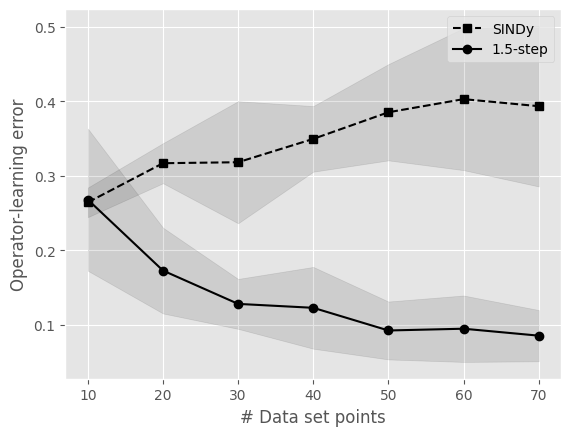

In [7]:
# Run loop
NUM_RUNS = 1
N_OBS = [int(i) for i in jnp.arange(10,80,10)]
# Operator learning errors plot
# plt.title('title')
n_obs = N_OBS
# Colors
c2 = 'black'
c1 = 'black'
# SINDy method plot
mean_i_opt_2 = jnp.array([jnp.nanmean(e) for e in jnp.array(err['SINDy'])])
sd_i_opt_2 = jnp.array([jnp.nanstd(e) for e in jnp.array(err['SINDy'])])

# SINDy method
plt.plot(n_obs, mean_i_opt_2, label = f'SINDy', marker= 's', color = c2,linestyle = 'dashed')
plt.fill_between(n_obs, mean_i_opt_2 - sd_i_opt_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = c2)
# plt.yscale('log')
plt.minorticks_off()
# 1_5 step method plot

# 1_5 method
mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'])])
sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'])])
# Plot 1_5 method
plt.plot(n_obs, mean_i_opt_1_5, label =  f'1.5-step', marker= 'o', color = c1)
plt.fill_between(n_obs, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
# plt.yscale('log')
plt.minorticks_off()

plt.legend()

plt.ylabel('Operator-learning error')
plt.xlabel('# Data set points')
# # adding labels to the plotlines
# xvals_2step = [5]*4 + [7.5]
# xvals_1step = [6.5]+[7]*4
# xvals = xvals_2step + xvals_1step
# lines = plt.gca().get_lines()
# labelLines(lines, align=True, xvals = xvals)
# # add legend box
# legend_elements = [Line2D([0], [0], color= c2, label='2-step'),
#                    Line2D([0], [0], color= c1, label='1.5-step')]
# plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()

In [8]:
err['SINDy']

[[Array(0.29145509, dtype=float64),
  Array(0.25822317, dtype=float64),
  Array(nan, dtype=float64),
  Array(0.2440008, dtype=float64),
  Array(nan, dtype=float64)],
 [Array(0.29829514, dtype=float64),
  Array(0.29795801, dtype=float64),
  Array(nan, dtype=float64),
  Array(0.35510925, dtype=float64),
  Array(nan, dtype=float64)],
 [Array(0.37451281, dtype=float64),
  Array(0.37825707, dtype=float64),
  Array(nan, dtype=float64),
  Array(0.20254364, dtype=float64),
  Array(nan, dtype=float64)],
 [Array(0.36575204, dtype=float64),
  Array(0.39387141, dtype=float64),
  Array(nan, dtype=float64),
  Array(0.28964718, dtype=float64),
  Array(nan, dtype=float64)],
 [Array(0.44570568, dtype=float64),
  Array(0.41494643, dtype=float64),
  Array(nan, dtype=float64),
  Array(0.29590623, dtype=float64),
  Array(nan, dtype=float64)],
 [Array(0.48328768, dtype=float64),
  Array(0.45686335, dtype=float64),
  Array(nan, dtype=float64),
  Array(0.26920403, dtype=float64),
  Array(nan, dtype=float64)],

## Save train data to be plugged into PINNSR

In [57]:
def get_data(n_obs,seed):
    # Sample 1 training functions as initial conditions from a GP
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = 2,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = seed
                                        )
                            
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.


    u_true_function,_,_,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )

    # Collocation point set size
    num_grid_x = 31
    num_grid_t = 26
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)
    

    # # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(seed),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    u_all = u_true_function(tx_all)

    # Collocation point set
    triplets_obs = jnp.hstack([tx_obs,u_obs[:,None]])
    triplets_obs = jax.random.permutation(key = jax.random.key(seed),x = triplets_obs)

    triplets_train = triplets_obs[:int(num_obs*0.8),:]
    triplets_val = triplets_obs[int(num_obs*0.8):,:]

    # Data point set
    tx_train = triplets_train[:,:2]
    u_train = triplets_train[:,-1]

    # Validation point set
    tx_val = triplets_val[:,:2]
    u_val = triplets_val[:,-1]

    # Test grid
    num_fine_grid = 300
    initial_time = 0
    final_time = 1
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

    u_fine = u_true_function(tx_fine)


    


    # Invert them to be ready for PINNSR
    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])
    
    tx_fine = tx_fine.at[:,[1,0]].set(tx_fine[:,[0,1]])

    triplets_obs = triplets_obs.at[:,[1,0]].set(triplets_obs[:,[0,1]])

    
    
    # Translate to same naming as in the NN
    X_u_train = tx_train
    u_train = u_train      
    X_f_train = tx_all # we don't concatenate since obs was obtained from coll
    X_u_val = tx_val
    u_val = u_val
    X_star = tx_fine
    u_star = u_fine
    # Domain bounds
    lb = tx_fine.min(0)
    ub = tx_fine.max(0) 
    
    return X_u_train, u_train, X_u_val, u_val, X_f_train, X_star, u_star, lb, ub, triplets_obs

In [58]:
X_u_train, u_train, X_u_val, u_val, X_f_train, X_star, u_star, lb, ub, triplets_obs = get_data(60,0)

  0%|          | 0/10099 [00:00<?, ?it/s]

In [48]:
lb, ub

(Array([0., 0.], dtype=float64), Array([1., 1.], dtype=float64))

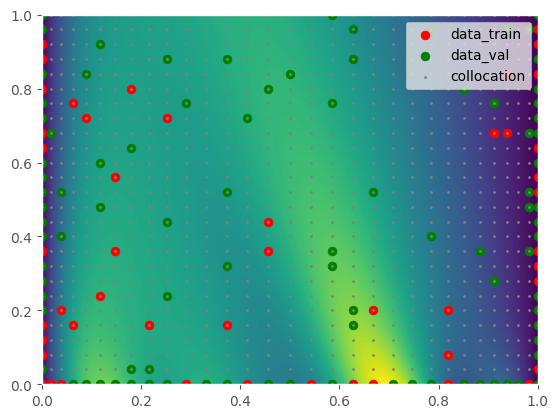

In [60]:
plt.tricontourf(*X_star.T, u_star, 200)
# plt.scatter(*triplets_obs[:,:2].T, s= 40, color ='red', label = 'data')
plt.scatter(*X_u_train.T, s= 40, color ='red', label = 'data_train')
plt.scatter(*X_u_val.T, s= 40, color ='green', label = 'data_val')
plt.scatter(*X_f_train.T, s= 2, color ='gray', label = 'collocation')
plt.legend(loc = 'upper right')
plt.show()

In [50]:
import scipy

data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
# data = scipy.io.loadmat(os.path.dirname(os.path.dirname(os.getcwd())) + '\\burgers.mat')
# data = scipy.io.loadmat('burgers.mat')

t = np.real(data['t'].flatten()[:,None])
x = np.real(data['x'].flatten()[:,None])
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    
    
# Measurement data
# In this case, measurements are from N_u_s points and continuously sampled all the time.
N_u_s = 10 
idx_s = np.random.choice(x.shape[0], N_u_s, replace=False)
X0 = X[:, idx_s]
T0 = T[:, idx_s]
Exact0 = Exact[:, idx_s]

N_u_t = int(t.shape[0]*1)
idx_t = np.random.choice(t.shape[0], N_u_t, replace=False)
X0 = X0[idx_t, :]
T0 = T0[idx_t, :]
Exact0 = Exact0[idx_t, :]

X_u_meas = np.hstack((X0.flatten()[:,None], T0.flatten()[:,None]))
u_meas = Exact0.flatten()[:,None]   

# Training measurements, which are randomly sampled spatio-temporally
Split_TrainVal = 0.8
N_u_train = int(X_u_meas.shape[0]*Split_TrainVal)
idx_train = np.random.choice(X_u_meas.shape[0], N_u_train, replace=False)
X_u_train = X_u_meas[idx_train,:]
u_train = u_meas[idx_train,:]

# Validation Measurements, which are the rest of measurements
idx_val = np.setdiff1d(np.arange(X_u_meas.shape[0]), idx_train, assume_unique=True)
X_u_val = X_u_meas[idx_val,:]
u_val = u_meas[idx_val,:]
        
# Collocation points
N_f = 50000

X_f_train = lb + (ub-lb)*lhs(2, N_f)
#    X_f_train = lb + (ub-lb)*sobol_seq.i4_sobol_generate(2, N_f)        
X_f_train = np.vstack((X_f_train, X_u_train))

In [51]:
lb,ub

(array([-8.,  0.]), array([ 7.9375, 10.    ]))

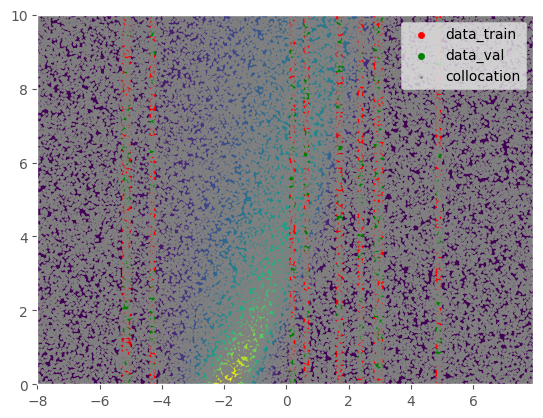

In [56]:
plt.tricontourf(*X_star.T, u_star.flatten(), 200)
# plt.scatter(*triplets_obs[:,:2].T, s= 40, color ='red', label = 'data')
plt.scatter(*X_u_train.T, s= 20, color ='red', label = 'data_train')
plt.scatter(*X_u_val.T, s= 20, color ='green', label = 'data_val')
plt.scatter(*X_f_train.T, s= 2, color ='gray', label = 'collocation')
plt.legend(loc = 'upper right')
plt.show()

  0%|          | 0/10099 [00:00<?, ?it/s]

(754, 2)
(806, 2)


NameError: name 'tx_train' is not defined

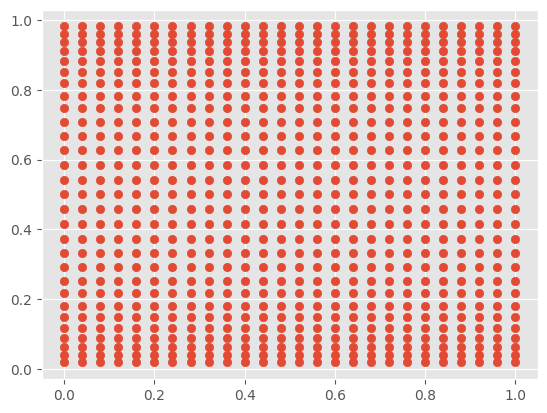

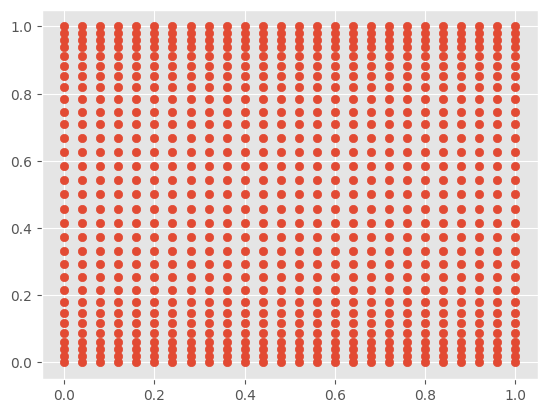

In [6]:
get_data(60,0)